# SCTLD Deep-Sequencing


This notebook will go through all the scripts I use in both bash and python to do an analysis of the deep sequencing metagenome data for 6 samples from SCTLD. At he top of each panel, I will add in what platform that particular code is being run in. 

In [ ]:
# naive_atlas (bash)
# raw data is processed using naive_atlas (https://github.com/TimothyStephens/naive_atlas)

naive_atlas init --db-dir databases path/to/fastq/files

naive_atlas run all

# for naive_altas settings see /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/naive_atlas/config.yaml


# First Steps on Analysis 

1. Identifying host reads: Run blast and subsequent blobtools to assess the contigs produced. 


2. Identify viruses using viral completeness: geneInfo.tsv (checkv completeness > 80%)


3. Size filtering MAGs: Select MAGs that have genome size >= 0.1Mbp 

In [ ]:
# blobtools 
# first I want to run it on just one assembly: N31_final_contigs.fasta which is a healthy coral colony. 
# N31 was 118,588 contigs 

#step 1: blast the contigs
/home/timothy/programs/ncbi-blast-2.13.0+/bin/blastn -db /scratch/databases/ncbi/2022_07/nt -out N31_contigs_blast_output.tsv -evalue 0.00001 -query N31_final_contigs.fasta -max_target_seqs 1 -num_threads 50 -outfmt 6 qseqid staxids bitscore #taxid for blobtools

# step 2: use blobtools to create a blobtools db
# need to create a sorted bam file

/home/timothy/programs/samtools-1.11/samtools sort N31.bam -o sorted_N31.bam -@ 60

# create an indexed bam file 
/home/timothy/programs/samtools-1.11/samtools index sorted_N31.bam

/home/shrinivas/Programs/blobtools/blobtools create -i /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/blobtools/N31_final_contigs.fasta -b /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/blobtools/sorted_N31.bam \
--db /home/shrinivas/Programs/blobtools/data/nodesDB.txt -o blob_db_SCTLD -t /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/blobtools/N31_contigs_blast_output.tsv


/home/shrinivas/Programs/blobtools/blobtools view -i /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/blobtools/blob_db_SCTLD.blobDB.json && \
/home/shrinivas/Programs/blobtools/blobtools plot -i /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/blobtools/blob_db_SCTLD.blobDB.json




**Blobtools results**

[I]     Cnidaria : sequences = 87,782, span = 313.43 MB, N50 = 5,319 nt
[I]     no-hit : sequences = 29,057, span = 50.16 MB, N50 = 1,689 nt
[I]     Ascomycota : sequences = 1,125, span = 1.77 MB, N50 = 1,510 nt
[I]     Chordata : sequences = 175, span = 0.47 MB, N50 = 3,048 nt
[I]     Eukaryota-undef : sequences = 115, span = 0.3 MB, N50 = 3,144 nt
[I]     Arthropoda : sequences = 112, span = 0.23 MB, N50 = 2,118 nt
[I]     Mollusca : sequences = 40, span = 0.09 MB, N50 = 2,982 nt
[I]     Echinodermata : sequences = 29, span = 0.09 MB, N50 = 3,459 nt
[I]     other : sequences = 153, span = 0.29 MB, N50 = 1,822 nt


Now using this data I want to make a draft Cnidaria genome

In [ ]:
/home/timothy/programs/seqkit_v2.3.1/seqkit grep -f cnidaria_contig_headers.txt N31_final_contigs.fasta -o diploria_contigs.fasta

# busco completness
busco -i diploria_contigs.fasta -o trial_output -m genome l eukaryota_odb10 --cpu 50

# bbstats
bbstats.sh diploria_contigs.fasta # 366 Mbp


jellyfish count -t 50 -C -m 21 -s 50G -o 21_diplo_mer_out /common/Tutorial/Genome_estimation/sample_read_1.fastq.gz /common/Tutorial/Genome_estimation/sample_read_2.fastq



Busco score: C:36.5%[S:35.7%,D:0.8%],F:43.1%,M:20.4%,n:255 

In [ ]:
conda '''
# Coverm analysis 
1. Coverm to obtain raw counts --methods count (for ANCOM)
2. Coverm to obtain tpm -- methods tpm (for t-test)
'''

##### Generate multiple sorted bam file###
# remember to use the complete bam files. Always found in path /naive_atlas/genomes/alignments/bams

#samtools 
#!/bin/bash

# Directory where your .bam files are stored
INPUT_DIR="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/naive_atlas/genomes/alignments/bams"
# Samtools binary path
SAMTOOLS="/home/timothy/programs/samtools-1.11/bin/samtools"
# Number of threads
THREADS=50

# Loop through all .bam files in the directory
for BAM_FILE in ${INPUT_DIR}/*.bam
do
    #Get the base name without .bam extension
    BASE_NAME=$(basename ${BAM_FILE} .bam)
    # Define the output sorted file name
    OUTPUT_FILE="sorted_${BASE_NAME}.bam"
    # Run samtools sort
    ${SAMTOOLS} sort ${BAM_FILE} -o ${OUTPUT_FILE} --threads ${THREADS}

    echo "Sorted ${BAM_FILE} to ${OUTPUT_FILE}"
done


####### coverm commands #######
coverm genome -m tpm --bam-files /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/naive_atlas/genomes/alignments/bams/sorted_N29.bam --genome-fasta-directory /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/naive_atlas/genomes/genomes/ -x .fasta --threads 50 -o N29_tpm_coverm.csv


######## merge all output files #######
import ossls
import pandas as pd

# Path to the directory containing the CSV files
directory = '/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/coverm'

# List to store DataFrames
dfs = []

# Iterate over the CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Merge all DataFrames on the 'Genome' column
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='Genome', how='outer')

# Save the merged DataFrame to a CSV file
output_file = 'merged.csv'
merged_df.to_csv(output_file, index=False)

print(f"Merged CSV saved as '{output_file}'.")




#### Basic MAG info ####

In [3]:
# Genome_analysis 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/Shrini/Desktop/SCTLD/genome_quality.tsv', sep='\t')
column_headers = df.columns.tolist()
column_headers


['Unnamed: 0',
 'Completeness',
 'Completeness_General',
 'Contamination',
 'Completeness_Specific',
 'Completeness_Model_Used',
 'Translation_Table_Used',
 'Coding_Density',
 'Contig_N50',
 'Average_Gene_Length',
 'Genome_Size',
 'GC_Content',
 'Total_Coding_Sequences',
 'Total_Contigs',
 'Max_Contig_Length',
 'Additional_Notes',
 'Quality_score',
 'Sample',
 'Ambigious_bases',
 'Length_contigs',
 'Length_scaffolds',
 'N50',
 'N_contigs',
 'N_scaffolds',
 'logN50',
 'archaea_odb10_Complete',
 'archaea_odb10_Single',
 'archaea_odb10_Duplicated',
 'archaea_odb10_Fragmented',
 'archaea_odb10_Missing',
 'bacteria_odb10_Complete',
 'bacteria_odb10_Single',
 'bacteria_odb10_Duplicated',
 'bacteria_odb10_Fragmented',
 'bacteria_odb10_Missing',
 'eukaryota_odb10_Complete',
 'eukaryota_odb10_Single',
 'eukaryota_odb10_Duplicated',
 'eukaryota_odb10_Fragmented',
 'eukaryota_odb10_Missing',
 'Sample.1',
 'checkv_completeness',
 'checkv_contamination',
 'checkv_quality',
 'checkv_miuvig_quality',

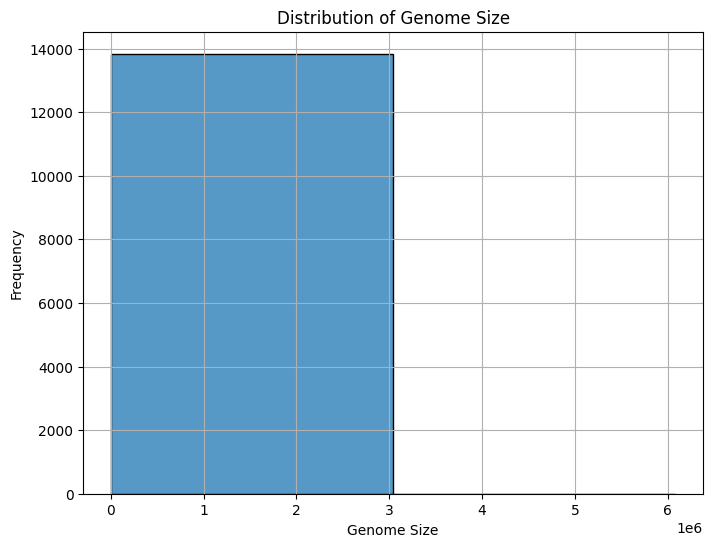

In [6]:
# genome size filtering 
plt.figure(figsize=(8, 6))
sns.histplot(df['Genome_Size'], kde=False, bins=2)
plt.title('Distribution of Genome Size')
plt.xlabel('Genome Size')
plt.ylabel('Frequency')
plt.grid(True)

plt.show() 

# clearly majority of the bins we got are tiny. 

In [34]:
genome_size = df[df['Genome_Size'] > 100000]
checkv = df[df['checkv_completeness']>=90]
MAGs_downstream = pd.concat([genome_size, checkv])
MAGs_downstream_unique = MAGs_downstream.drop_duplicates(subset=MAGs_downstream.columns[0], keep='first')
MAGs_downstream_unique

,Unnamed: 0,Completeness,Completeness_General,Contamination,Completeness_Specific,Completeness_Model_Used,Translation_Table_Used,Coding_Density,Contig_N50,Average_Gene_Length,...,checkv_completeness,checkv_contamination,checkv_quality,checkv_miuvig_quality,Sample.2,plasme_reference,plasme_order,plasme_evidence,plasme_score,Sample.3
2,MAG00003,6.38,6.38,0.0,2.25,Gradient Boost (General Model),11.0,0.068,4549.0,113.531250,...,70.88,0.0,Medium-quality,Genome-fragment,N29,NaN,NaN,NaN,NaN,NaN
3,MAG00004,2.38,6.38,0.0,2.38,Neural Network (Specific Model),11.0,0.196,4233.0,82.509804,...,NaN,0.0,Not-determined,Genome-fragment,N29,NaN,NaN,NaN,NaN,NaN
13,MAG00014,6.38,6.38,0.0,2.19,Gradient Boost (General Model),11.0,0.024,11643.0,60.642857,...,NaN,0.0,Not-determined,Genome-fragment,N29,NaN,NaN,NaN,NaN,NaN
14,MAG00015,6.38,6.38,0.0,2.32,Gradient Boost (General Model),11.0,0.043,4487.0,133.666667,...,NaN,0.0,Not-determined,Genome-fragment,N29,NaN,NaN,NaN,NaN,NaN
18,MAG00019,2.51,6.38,0.0,2.51,Neural Network (Specific Model),11.0,0.178,5633.0,118.521368,...,100.00,0.0,High-quality,High-quality,N29,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13532,MAG13533,6.38,6.38,0.0,2.19,Gradient Boost (General Model),11.0,0.861,5068.0,292.400000,...,100.00,0.0,High-quality,High-quality,N37,NaN,NaN,NaN,NaN,NaN
13598,MAG13599,6.38,6.38,0.0,2.21,Gradient Boost (General Model),11.0,0.625,5331.0,136.400000,...,91.13,0.0,High-quality,High-quality,N37,NaN,NaN,NaN,NaN,NaN
13646,MAG13647,2.29,6.38,0.0,2.29,Neural Network (Specific Model),11.0,0.974,15730.0,1593.600000,...,100.00,0.0,High-quality,High-quality,N37,NaN,NaN,NaN,NaN,NaN
13743,MAG13744,6.38,6.38,0.0,2.19,Gradient Boost (General Model),11.0,0.680,5432.0,205.333333,...,100.00,0.0,High-quality,High-quality,N37,NaN,NaN,NaN,NaN,NaN


So only 11 bins were over 1Mbp. Therefore I lowered the net total required to 0.1Mbp (100k). \
There are only 525 bins of high quality viruses. \
Of the bins of interest when merged, there are 103 that are duplicated out of 1,103. \
**So now we have exactly 1,000 bins of interest**

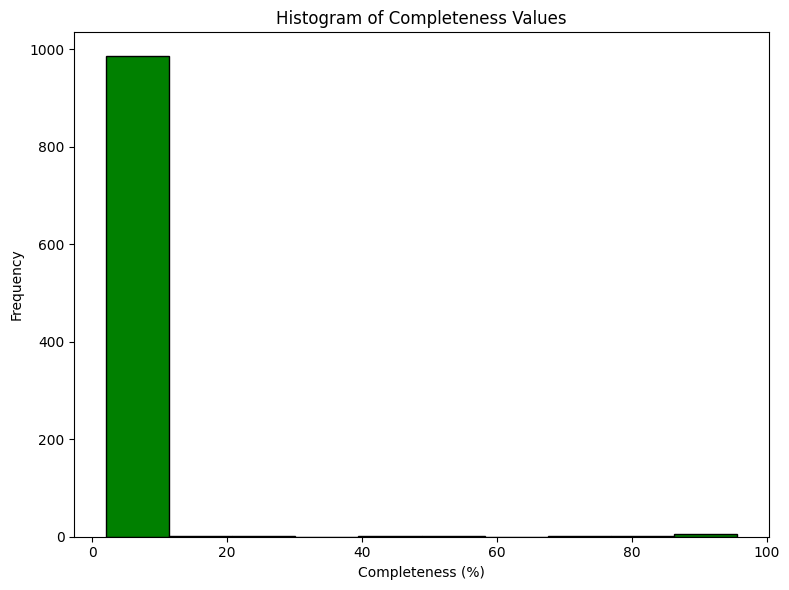

In [36]:
plt.figure(figsize=(8, 6))
plt.hist(MAGs_downstream_unique['Completeness'], bins=10, color='green', edgecolor='black')
plt.xlabel('Completeness (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Completeness Values')
plt.tight_layout()

# To display the plot
plt.show()

## PCA Analysis

# Differential Abundance Analysis 

So there are multiple ways this DAA can be done (https://www.nature.com/articles/s41467-022-28034-z). 

Need to read up on the tools that I want to work with here. Most likely will be tool in R. 
A leader in this appears to be Analysis of composition of microbiomes (ANCOM) series of tools.


I want to run ANCOM and also do a simpler t-test. That is using tpm values obtained from coverm and subsequently FC and t-test to assess everything. 
Check if data is normal or not before running t-test.



## Standard t-test (with FC)

In [3]:
# generate my data of interest ie a counts table with tpm
# generarte bins of interest 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/genome_quality.tsv', sep='\t')
gen_mags = df[df['Genome_Size'] >=100000]
viral_mags = df[df['checkv_completeness'] >=90]

MAGs = pd.concat([gen_mags, viral_mags]).drop_duplicates(keep='first')
MAGs = MAGs.rename(columns={'Unnamed: 0': 'Genome'})
#MAGs

# load in the coverage in the tpm 
tpm = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/coverm/coverm_tpm_output.csv')

# porduce a table of MAgs of interest and their coverm output
MAGs = pd.merge(MAGs, tpm, on="Genome", how="left")
MAGs = MAGs.set_index("Genome")
counts = MAGs.iloc[:, -6:]

#cleaning up and loading datasets for using in DAA 
counts.columns = counts.columns.str.replace('TPM', '', regex=False)
counts.columns = counts.columns.str.replace('sorted_', '', regex=False)

Sample_ID = pd.read_excel("/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/Metadata_SCTLD_deep_seq.xlsx")
Sample_ID
counts

,N36,N29,N37,N33,N31,N35
Genome,,,,,,
MAG00003,33.991756,58.348560,25.783154,39.684227,32.513577,45.073612
MAG00004,18.256964,52.365696,19.580156,12.799766,17.612440,14.283665
MAG00014,45.906097,85.042595,0.486745,57.662563,82.035030,43.569510
MAG00015,58.050785,56.514168,50.405968,33.296234,38.319930,37.100876
MAG00019,29.502401,52.843746,50.902615,27.460503,29.446184,29.508116
...,...,...,...,...,...,...
MAG13533,31.066124,48.082760,83.962010,74.216650,26.903700,80.372406
MAG13599,99.238815,82.146660,126.342170,88.780480,100.656540,92.317620
MAG13647,1.643272,0.362469,16.276701,2.292144,0.000000,0.268949


In [27]:
#counts = counts.reset_index()
counts = counts.set_index("Genome")

sorted_N36 TPM: W-statistic=0.6679521194534747, p-value=2.7616155277772344e-40
sorted_N36 TPM does not appear to be normally distributed (p <= 0.05).
sorted_N29 TPM: W-statistic=0.6798715372160687, p-value=9.176560376529787e-40
sorted_N29 TPM does not appear to be normally distributed (p <= 0.05).
sorted_N37 TPM: W-statistic=0.6965547859542407, p-value=5.245974846210455e-39
sorted_N37 TPM does not appear to be normally distributed (p <= 0.05).
sorted_N33 TPM: W-statistic=0.3075656914896492, p-value=1.6048633726236573e-51
sorted_N33 TPM does not appear to be normally distributed (p <= 0.05).
sorted_N31 TPM: W-statistic=0.7063105061346153, p-value=1.507927723435483e-38
sorted_N31 TPM does not appear to be normally distributed (p <= 0.05).
sorted_N35 TPM: W-statistic=0.5263650720267699, p-value=1.5496449219007345e-45
sorted_N35 TPM does not appear to be normally distributed (p <= 0.05).


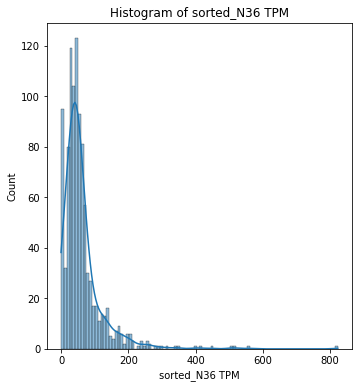

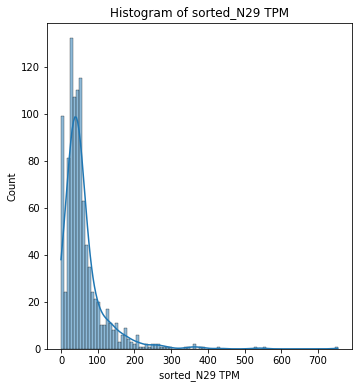

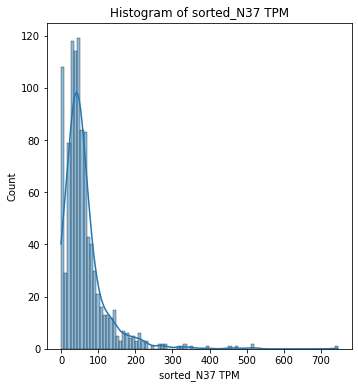

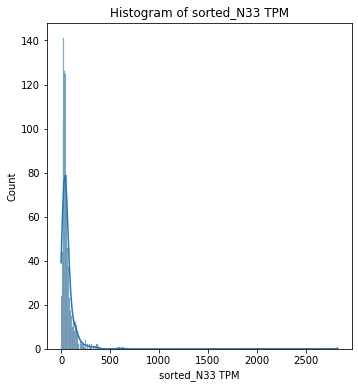

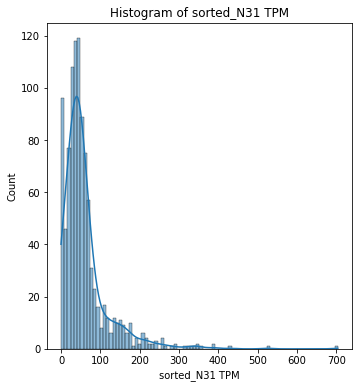

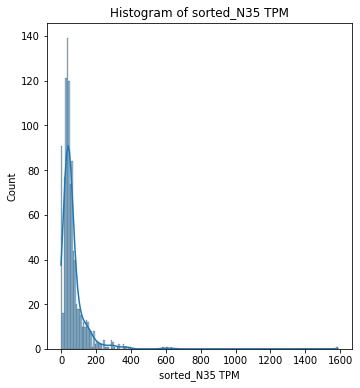

In [3]:
# check if the data is normal
# check if data is normally distributed
from scipy import stats

for column in counts.columns:
    stat, p_value = stats.shapiro(counts[column])
    print(f"{column}: W-statistic={stat}, p-value={p_value}")
    
    # Check p-value to determine normality
    if p_value > 0.05:
        print(f"{column} appears to be normally distributed (p > 0.05).")
    else:
        print(f"{column} does not appear to be normally distributed (p <= 0.05).")

for column in counts.columns:
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(counts[column], kde=True)
    plt.title(f'Histogram of {column}')

Cleary none of our observed data is normally distributed. 
Our samples are all independent and are not paired. 
Ideally we would have use a classic t-test to verify statistical significance of our MAGs. 
However, since the data is not normal we will have to use a non-parametric test. 
2 possible tests, the Kruskal Wallis test or the Mann Whitney U test. 
The KW test is more similar to a one-way ANOVA while the MW test is more of a non-parametric t-test. 
Therefore I will be using the MW test for this analysis. 
Of course once we get more samples we would want to run ANCOM to verify our findings. 

In [28]:
# prepr the data for DAA 
# Filter for each treatment group
T1_samples = Sample_ID[Sample_ID['Treatment'] == 'Diseased']
T2_samples = Sample_ID[Sample_ID['Treatment'] == 'AH']
T3_samples = Sample_ID[Sample_ID['Treatment'] == 'Healthy']


# extract the Sample_ID for each group 
T1_sample_ids = T1_samples['Sample_ID'].tolist()
T2_sample_ids = T2_samples['Sample_ID'].tolist()
T3_sample_ids = T3_samples['Sample_ID'].tolist()

# filter MAGs table samples based on this classification
T1_metabolites = counts[T1_sample_ids]  # Diseased
T2_metabolites = counts[T2_sample_ids]  # AH
T3_metabolites = counts[T3_sample_ids]  # Healthy


In [29]:
# load in packages 
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Find metabolites to keep based on row sums (non-zero rows in all groups)
t1 = np.where(T1_metabolites.sum(axis=1) > 0)[0]
t2 = np.where(T2_metabolites.sum(axis=1) > 0)[0]
t3 = np.where(T3_metabolites.sum(axis=1) > 0)[0]
tokeep = np.union1d(np.union1d(t1, t2), t3)

# perform the MWU test for each of the samples. Our key comparisions are DS vs H; AH vs H; DS vs AH
# Initialize lists to store p-values for each pairwise comparison
pval_D_vs_H = []  # Diseased vs Healthy
pval_AH_vs_H = []  # AH vs Healthy
pval_D_vs_AH = []  # Diseased vs AH

# Perform Mann-Whitney U test for each metabolite (pairwise comparisons)
for i in range(len(tokeep)):
    # Diseased vs Healthy
    _, p_value_D_vs_H = mannwhitneyu(T1_metabolites.iloc[i], T3_metabolites.iloc[i], alternative='two-sided')
    pval_D_vs_H.append(p_value_D_vs_H)
    
    # AH vs Healthy
    _, p_value_AH_vs_H = mannwhitneyu(T2_metabolites.iloc[i], T3_metabolites.iloc[i], alternative='two-sided')
    pval_AH_vs_H.append(p_value_AH_vs_H)
    
    # Diseased vs AH
    _, p_value_D_vs_AH = mannwhitneyu(T1_metabolites.iloc[i], T2_metabolites.iloc[i], alternative='two-sided')
    pval_D_vs_AH.append(p_value_D_vs_AH)

# Adjust p-values using Benjamini-Hochberg method (FDR correction)
pvalAdj_D_vs_H = multipletests(pval_D_vs_H, method='fdr_bh')[1]
pvalAdj_AH_vs_H = multipletests(pval_AH_vs_H, method='fdr_bh')[1]
pvalAdj_D_vs_AH = multipletests(pval_D_vs_AH, method='fdr_bh')[1]

In [30]:
# calculate the log2FC 

# Calculate log2 fold change for T1 (Diseased), T2 (AH), and T3 (Healthy)
T1_log2 = np.log2(T1_metabolites)
T1_log2.replace(-np.inf, 0, inplace=True)
T1_mean = T1_log2.mean(axis=1)

T2_log2 = np.log2(T2_metabolites)
T2_log2.replace(-np.inf, 0, inplace=True)
T2_mean = T2_log2.mean(axis=1)

T3_log2 = np.log2(T3_metabolites)
T3_log2.replace(-np.inf, 0, inplace=True)
T3_mean = T3_log2.mean(axis=1)

# Calculate fold change for each comparison
foldchange_D_vs_H = T1_mean - T3_mean  # Diseased vs Healthy
foldchange_AH_vs_H = T2_mean - T3_mean  # AH vs Healthy
foldchange_D_vs_AH = T1_mean - T2_mean  # Diseased vs AH


/Users/shrinivas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


In [31]:
stats = pd.DataFrame({
    'FC_D_vs_H': foldchange_D_vs_H,
    'FC_AH_vs_H': foldchange_AH_vs_H,
    'FC_D_vs_AH': foldchange_D_vs_AH,
    'pval_D_vs_H': pval_D_vs_H,
    'ADJPVALUE_D_vs_H': pvalAdj_D_vs_H,
    'pval_AH_vs_H': pval_AH_vs_H,
    'ADJPVALUE_AH_vs_H': pvalAdj_AH_vs_H,
    'pval_D_vs_AH': pval_D_vs_AH,
    'ADJPVALUE_D_vs_AH': pvalAdj_D_vs_AH
})



In [33]:
# prelim check on stats
sig1 = stats[stats['pval_D_vs_H'] <=0.05]
sig2 = stats[stats['pval_AH_vs_H'] <=0.05]
sig3 = stats[stats['pval_D_vs_AH'] <=0.05]

# quick check increased 
FC1 = stats[stats['FC_D_vs_H'] >=1.0]
FC2 = stats[stats['FC_AH_vs_H'] >= 1.0]
FC3 = stats[stats['FC_D_vs_AH'] >= 1.0]
num_rows = FC3.shape[0]

# quick check decreased abundance 
#FC1 = stats[stats['FC_D_vs_H'] <= -1.0]
#FC2 = stats[stats['FC_AH_vs_H'] <= -1.0]
#FC3 = stats[stats['FC_D_vs_AH'] <= -1.0]
#num_rows = FC3.shape[0]
FC1

,FC_D_vs_H,FC_AH_vs_H,FC_D_vs_AH,pval_D_vs_H,ADJPVALUE_D_vs_H,pval_AH_vs_H,ADJPVALUE_AH_vs_H,pval_D_vs_AH,ADJPVALUE_D_vs_AH
Genome,,,,,,,,,
MAG00014,3.470136,2.823228,0.646908,0.666667,0.993542,1.000000,1.0,0.333333,1.0
MAG00490,1.935853,2.292059,-0.356206,0.333333,0.993542,0.333333,1.0,1.000000,1.0
MAG00729,4.264524,3.541628,0.722896,0.333333,0.993542,0.666667,1.0,0.666667,1.0
MAG00999,1.469993,0.654840,0.815153,0.333333,0.993542,0.333333,1.0,0.666667,1.0
MAG01253,1.262009,0.516621,0.745389,0.333333,0.993542,1.000000,1.0,0.666667,1.0
...,...,...,...,...,...,...,...,...,...
MAG09805,2.277920,2.809370,-0.531451,0.666667,0.993542,0.333333,1.0,1.000000,1.0
MAG09880,1.269580,1.432382,-0.162802,0.666667,0.993542,0.333333,1.0,1.000000,1.0
MAG09968,2.739603,4.053899,-1.314296,0.333333,0.993542,0.333333,1.0,0.333333,1.0


A preliminary check to see if any of this is statisitically singificant. tho intial hypothesis is that majority of these would not be significant. Just because of lack of statistical power due to low replicate numbers. \

**Yup no statistical significant MAGs**
But there are log2FC MAGs that are interesting. Will have to look at their box plots too to actually make sense of anything. 

DS vs H = 109 (up) / 22 (down)

AH vs H = 46 (up) / 26 (down) 

DS vs AH = 81 (up) / 11 (down) 




In [34]:
merge = pd.concat([FC1, FC2], axis=0)  # axis=0 means concatenating row-wise
Up_MAG = pd.concat([merge, FC3], axis=0)  # axis=0 means concatenating row-wise
Up_MAG = Up_MAG.drop_duplicates(keep='first') # remove any duplicates
Up_MAG
candidates = Up_MAG.iloc[:, :3]
candidates

,FC_D_vs_H,FC_AH_vs_H,FC_D_vs_AH
Genome,,,
MAG00014,3.470136,2.823228,0.646908
MAG00490,1.935853,2.292059,-0.356206
MAG00729,4.264524,3.541628,0.722896
MAG00999,1.469993,0.654840,0.815153
MAG01253,1.262009,0.516621,0.745389
...,...,...,...
MAG08508,0.892166,1.416786,-0.524620
MAG11325,0.994719,1.852361,-0.857642
MAG11742,0.013098,1.011814,-0.998716


/var/folders/s1/31gd39_55zgcmsjz0xx9m46c0000gn/T/ipykernel_25598/3089083167.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['classification'] = candidates.apply(classify, axis=1)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Case IV'),
  Text(1, 0, 'Case I'),
  Text(2, 0, 'Case V'),
  Text(3, 0, 'Case VI'),
  Text(4, 0, 'Case II'),
  Text(5, 0, 'Case III')])

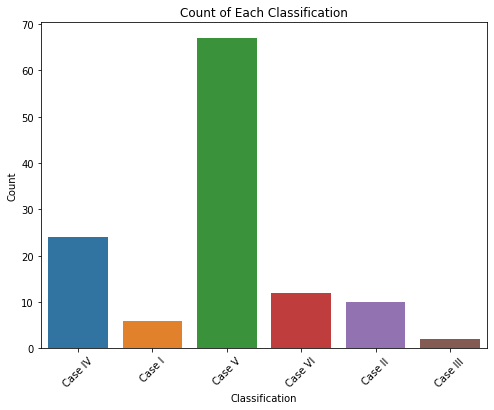

In [211]:
# look for correlation 
# if greater than 1.0 in col 1 and col2 say disease oriented 
# if only 1.0in col1 then say active disease oriented 
# if only >=1.0 in col2 say early onset
# if only in col3 say late onest 
# if in col1 and col3 say exlcusive disease state 

def classify(row):
    if row['FC_D_vs_H'] >= 1.0 and row['FC_AH_vs_H'] < 1.0 and row['FC_D_vs_AH'] < 1.0:
        return 'Case I'
    elif row['FC_AH_vs_H'] >= 1.0 and row['FC_D_vs_H'] < 1.0 and row['FC_D_vs_AH'] < 1.0:
        return 'Case II'
    elif row['FC_D_vs_AH'] >= 1.0 and row['FC_D_vs_H'] < 1.0 and row['FC_AH_vs_H'] < 1.0:
        return 'Case III'
    elif row['FC_D_vs_H'] >= 1.0 and row['FC_AH_vs_H'] >= 1.0 and row['FC_D_vs_AH'] < 1.0:
        return 'Case IV'
    elif row['FC_D_vs_H'] >= 1.0 and row['FC_D_vs_AH'] >= 1.0 and row['FC_AH_vs_H'] < 1.0: 
        return 'Case V'
    elif row['FC_D_vs_H'] >= 1.0 and row['FC_D_vs_AH'] >= 1.0 and row['FC_AH_vs_H'] >= 1.0:
        return 'Case VI'
    else:
        return 'unclassified'

candidates['classification'] = candidates.apply(classify, axis=1)


plt.figure(figsize=(8, 6))
sns.countplot(x='classification', data=candidates)

# Add labels and title
plt.title('Count of Each Classification')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

In [35]:
##**Assign Viral, other, both**

df['checkv_completeness'] = df['checkv_completeness'].fillna(0)

def classify(row):
    if row['Genome_Size'] >= 100000 and row['checkv_completeness'] >= 90:
        return 'Both'
    elif row['Genome_Size'] >= 100000 and row['checkv_completeness'] < 90:
        return 'Microbe'
    elif row['Genome_Size'] < 100000 and row['checkv_completeness'] >= 90:
        return 'Viral'
    else:
        return 'unclassified'

df['taxa'] = df.apply(classify, axis=1)
df = df.rename(columns={'Unnamed: 0': 'Genome'})
#candidates = candidates.reset_index()

In [36]:
trial = pd.merge(candidates, df, on="Genome", how="left")
columns_to_keep = ['Genome', 'FC_D_vs_H', 'FC_AH_vs_H', 
                   'FC_D_vs_AH', 'classification', 'Genome_Size',
                  'checkv_completeness', 'Completeness', 'taxa']  # Replace with your actual column names

# Subset the DataFrame with the specified columns
candidates = trial[columns_to_keep]
candidates

KeyError: "['classification'] not in index"

(array([0, 1, 2]),
 [Text(0, 0, 'Microbe'), Text(1, 0, 'Both'), Text(2, 0, 'Viral')])

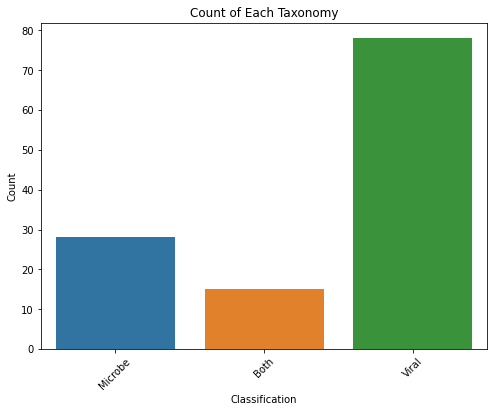

In [255]:
plt.figure(figsize=(8, 6))
sns.countplot(x='taxa', data=candidates)

# Add labels and title
plt.title('Count of Each Taxonomy')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

The differentially abundant bins are primarily highly complete viruses > 90%

# PCA


/Users/shrinivas/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


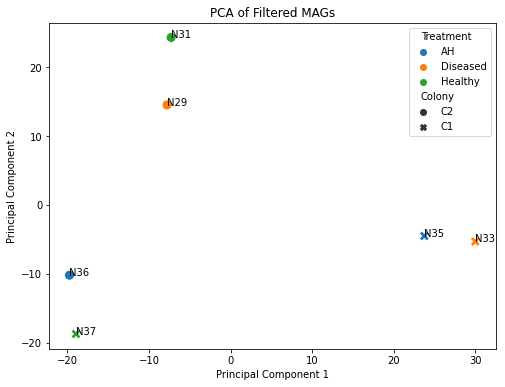

In [142]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

init = counts.transpose()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(init)

# 2. Run PCA
pca = PCA(n_components=2)  # We are choosing 2 components for visualization
pca_result = pca.fit_transform(df_scaled)

# 3. Create a DataFrame with the PCA results for easier plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=init.index)
pca_df

# manually add in the metadata to the PCA
pca_df['Treatment'] = ['AH', 'Diseased', 'Healthy', 'Diseased', 'Healthy', 'AH']
pca_df['Colony'] = ['C2', 'C2', 'C1', 'C1', 'C2', 'C1']

plt.figure(figsize=(8, 6))
sns.scatterplot(pca_df['PC1'], pca_df['PC2'], hue=pca_df['Treatment'], style=pca_df['Colony'], s=100)

# Add labels for the columns (optional)
for i, col in enumerate(counts.columns):
    plt.text(pca_df['PC1'][i], pca_df['PC2'][i], col)

plt.title('PCA of Filtered MAGs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.savefig('PCA_Deep_seq.pdf')
plt.show()

In [143]:
explained_variance = pca.explained_variance_ratio_ * 100

for i, var in enumerate(explained_variance):
    print(f"Principal Component {i+1} explains {var:.2f}% of the variance")
    

# Optionally, you can also plot the explained variance
'''
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=[f'PC{i+1}' for i in range(len(explained_variance))])
plt.title('Percentage of Variance Explained by Each PC')
plt.xlabel('Principal Components')
plt.ylabel('% Variance Explained')
plt.show()
'''

Principal Component 1 explains 38.74% of the variance
Principal Component 2 explains 21.76% of the variance


"\nplt.figure(figsize=(6, 4))\nplt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=[f'PC{i+1}' for i in range(len(explained_variance))])\nplt.title('Percentage of Variance Explained by Each PC')\nplt.xlabel('Principal Components')\nplt.ylabel('% Variance Explained')\nplt.show()\n"

# Clustered Heatmap

I'll do multiple in the following order 
1. All filtered 
2. log2 transformed and filtered 

Between the two I dont think it matters in terms of clustering which one you do. So I am sticking with the log2 one just cuz it looks a lil more aesthetic.

3. Increased abundance ones only 

In [156]:
# fixing the names just so its easier to read
counts.columns = counts.columns.str.replace(' ', '', regex=False)

counts = counts.rename(columns={
    'N36': 'N36_AH_C2', 
    'N29': 'N29_DS_C2',
    'N37': 'N37_H_C1', 
    'N33': 'N33_DS_C1',
    'N31': 'N31_H_C2', 
    'N35': 'N35_AH_C1'
})
counts


log2_transformed_df = np.log(counts+1)


,N36_AH_C2,N29_DS_C2,N37_H_C1,N33_DS_C1,N31_H_C2,N35_AH_C1
Genome,,,,,,
MAG00003,33.991756,58.348560,25.783154,39.684227,32.513577,45.073612
MAG00004,18.256964,52.365696,19.580156,12.799766,17.612440,14.283665
MAG00014,45.906097,85.042595,0.486745,57.662563,82.035030,43.569510
MAG00015,58.050785,56.514168,50.405968,33.296234,38.319930,37.100876
MAG00019,29.502401,52.843746,50.902615,27.460503,29.446184,29.508116
...,...,...,...,...,...,...
MAG13533,31.066124,48.082760,83.962010,74.216650,26.903700,80.372406
MAG13599,99.238815,82.146660,126.342170,88.780480,100.656540,92.317620
MAG13647,1.643272,0.362469,16.276701,2.292144,0.000000,0.268949


[None, None, None, None, None, None]

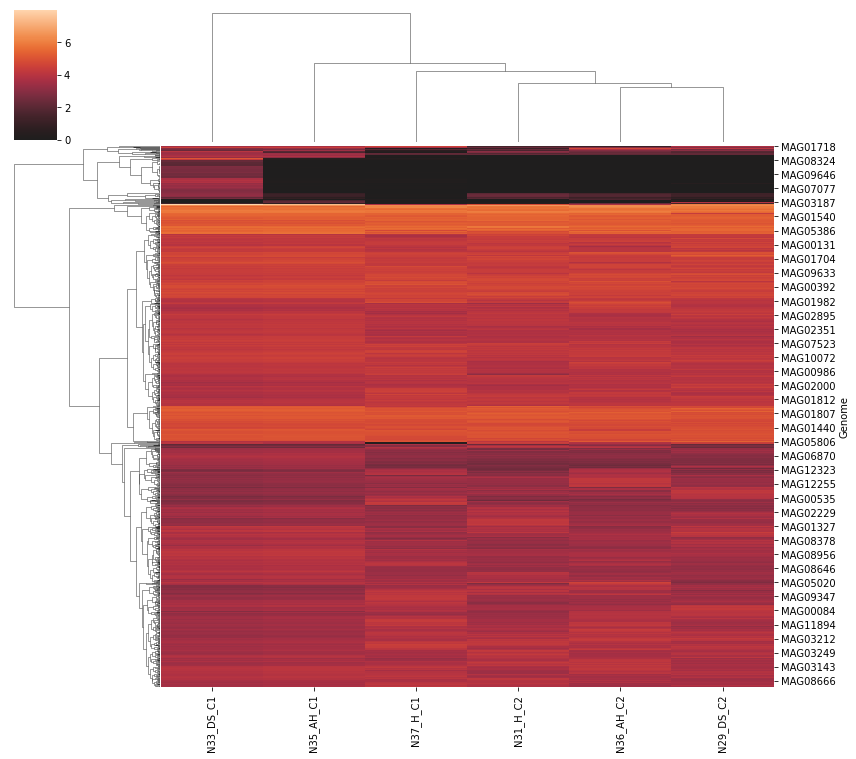

In [175]:
g = sns.clustermap(log2_transformed_df, method = 'complete', metric ='euclidean', 
               row_cluster = "True", col_cluster ="True", cbar_kws={"shrink": 0.5},
               dendrogram_ratio=(0.2, 0.2),
                center=0, figsize=(12, 10))

# Rotate the x-axis labels by 90 degrees
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)


Standard scale zero standardizes the the dimension, in our case the row (0). This is from each row, subtract the minimum and divide by the maximum. The closer you are to 1 means the higher your value actually was. 0 means it was the minimum in a particular row 


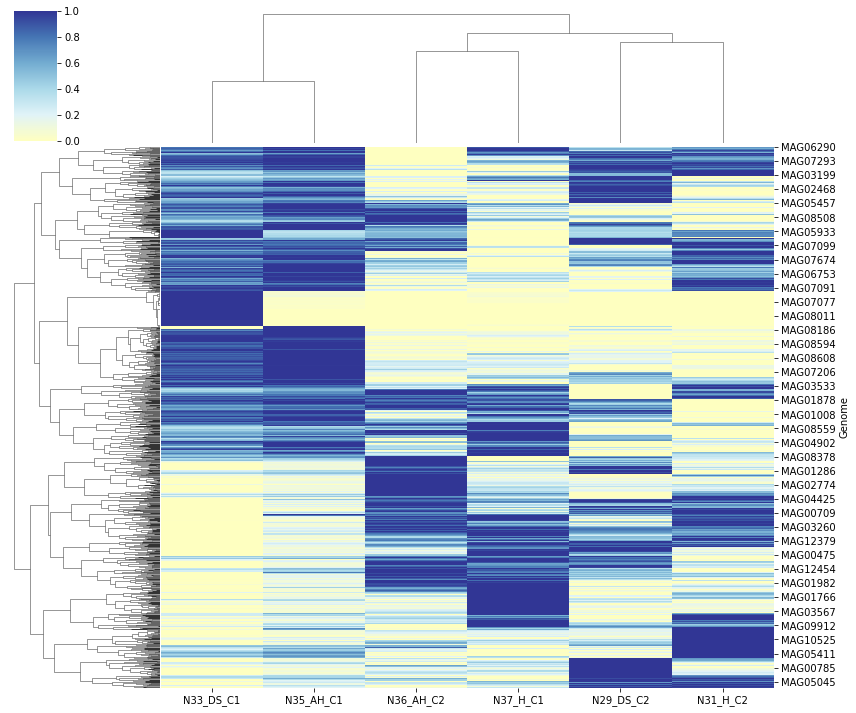

In [179]:
#log transform the data

fig = sns.clustermap(log2_transformed_df, method = 'complete', metric ='euclidean', 
               row_cluster = "True", col_cluster ="True",  cmap='RdYlBu', cbar_kws={"shrink": 0.5}, standard_scale=0,
               dendrogram_ratio=(0.2, 0.2),
                center=0, figsize=(12, 10))

fig

print("Standard scale zero standardizes the the dimension, in our case the row (0). This is from each row, subtract the minimum and divide by the maximum. The closer you are to 1 means the higher your value actually was. 0 means it was the minimum in a particular row ")

In [256]:
candidates.to_csv('SCTLD_MAG.csv')

# Working with Bins of interest 
**Primarily bash scripts**

Step 0: Predict ORF

Step 1. Taxonomic ID of all bins detected. 

    use checkv for all 
    use geNomad
    use virify 
    
Step 2. Viral bins will need to be blast

Step 2a: For bacterial tiara 

Step 3. Blast against viral database (nr)

Step 4. Complete blast 

Step 5. Gtdbk of bacteria

**All of this has now been completed.**

In [ ]:
# move this bins of interest ######

#!/bin/bash

# Define the file with the list of file names and the destination directory
file_list="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/bacterial_bins/bacterial_list.txt"  # Update with the path to your .txt file
source_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes"  # Update with the source directory where the files are located
destination_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/bacterial_bins/bacterial_genomes"  # Update with the destination directory

# Loop through each file listed in the .txt file and copy only those .fasta files
while IFS= read -r filename; do
    # If the file exists in the source directory and has .fasta extension, copy it
    if [[ -f "$source_dir/$filename.fasta" ]]; then
        cp "$source_dir/$filename.fasta" "$destination_dir"
    else
        echo "File $filename.fasta not found in source directory."
    fi
done < "$file_list"


In [ ]:
## prodigal to predict stuff 
# Define directories
input_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes"  # Modify this to your input directory path
output_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes/prodigal_output"  # Modify this to your desired output directory

# Create the output directory if it doesn't exist
mkdir -p "$output_dir"

# Loop through all .fa files in the directory
for fa_file in "$input_dir"/*.fasta; do
    # Extract the base filename without extension
    base_name=$(basename "$fa_file" .fasta)

    # Define output file names based on the base name
    output_gbk="$output_dir/${base_name}_genes.gbk"
    output_protein="$output_dir/${base_name}_protein.faa"

    # Run Prodigal
    prodigal -i "$fa_file" -o "$output_gbk" -a "$output_protein" -p meta
done

echo "Prodigal processing complete."

In [ ]:
# running checkv 
export CHECKVDB=/scratch/shrinivas/Databases/checkv-db-v1.5/ # provide db file 


checkv end_to_end input_file.fna output_directory -t 16 # base command for just one file 

################## loop command ################

#!/bin/bash

# Define the directories
input_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes"  # Modify this to your input directory containing .fna files
output_dir_base="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/checkv"  # Modify this to the base output directory

# Create the output directory if it doesn't exist
mkdir -p "$output_dir_base"

# Loop through all .fna files in the directory
for fna_file in "$input_dir"/*.fasta; do
    # Extract the base filename without extension
    base_name=$(basename "$fna_file" .fasta)

    # Define the specific output directory for each file
    output_dir="$output_dir_base/${base_name}_checkv_output"

    # Create the output directory for this file
    mkdir -p "$output_dir"

    # Run CheckV with 16 threads
    checkv end_to_end "$fna_file" "$output_dir" -t 50

    echo "CheckV completed for $fna_file"
done

echo "All CheckV processing complete."



In [ ]:
# trial with virify 
conda create -n singularity conda-forge::singularity


/home/shrinivas/Programs/next_flow/nextflow run EBI-Metagenomics/emg-viral-pipeline -r v0.4.0 --fasta "/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes/virify_trial/MAG08250.fasta" --cores 20 -profile local,singularity -resume


#!/bin/bash
# Loop through all fasta files in the specified directory
for fasta_file in /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes/viral_associated/attempt2_virify/*.fasta
do
    /home/shrinivas/Programs/next_flow/nextflow run EBI-Metagenomics/emg-viral-pipeline -r v0.4.0 \
    --fasta "$fasta_file" \
    --cores 50 \
    -profile local,singularity \
    --databases /scratch/shrinivas/Databases/nextflow-autodownload-databases/ \
    --workdir /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes/viral_associated/attempt2_virify/virify_work
done


# re running with all MAG being just one contig 
'''
grep -v "^>" MAG11742.fasta | tr -d '\n' > cat_MAG11742.fasta

sed -i "1i >MAG11742.fasta" cat_MAG11742.fasta

'''

# same code as above but for all fasta
#!/bin/bash

# Set the directory containing the fasta files
fasta_dir="/path/to/your/fasta/files"

# Loop through each fasta file in the directory
for fasta_file in "$fasta_dir"/*.fasta; do
    # Extract the base name without the .fasta extension
    base_name=$(basename "$fasta_file" .fasta)
    
    # Concatenate sequences without headers and remove newlines
    grep -v "^>" "$fasta_file" | tr -d '\n' > "cat_${base_name}.fasta"
    
    # Add the sequence header based on the file name
    sed -i "1i >${base_name}" "cat_${base_name}.fasta"
    
    echo "Processed ${fasta_file} -> cat_${base_name}.fasta"
done



In [ ]:
# move this bins of interest ######

#!/bin/bash

# Define the file with the list of file names and the destination directory
file_list="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes/MAGs.txt"  # Update with the path to your .txt file
source_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes/"  # Update with the source directory where the files are located
destination_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/genomes/viral_associated"  # Update with the destination directory

# Loop through each file listed in the .txt file and copy only those .fasta files
while IFS= read -r filename; do
    # If the file exists in the source directory and has .fasta extension, copy it
    if [[ -f "$source_dir/$filename.fasta" ]]; then
        cp "$source_dir/$filename.fasta" "$destination_dir"
    else
        echo "File $filename.fasta not found in source directory."
    fi
done < "$file_list"


# Blast results viral

In [16]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/blast_results_viral.tsv')
df

/var/folders/s1/31gd39_55zgcmsjz0xx9m46c0000gn/T/ipykernel_14025/3168567682.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/blast_results_viral.tsv')


,Unnamed: 0,qseqid,Accession,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,staxid,Function,Species,Unnamed: 3,Unnamed: 4
0,0,MAG00044_1_1,YP_009666308.1,28.734,964,615,23,652,1576,97,1027,3.010000e-108,375.0,0,Reverse Transcriptase,NaN,NaN,NaN
1,1,MAG00044_1_1,YP_009507248.1,34.839,465,277,9,840,1292,127,577,1.020000e-69,260.0,0,ORF B,Trichoplusia ni TED virus],NaN,NaN
2,2,MAG00044_1_1,NP_043933.1,29.017,641,407,14,667,1276,79,702,1.640000e-61,228.0,0,NaN,NaN,NaN,NaN
3,3,MAG00044_1_1,YP_010805169.1,31.696,448,284,5,840,1276,272,708,1.170000e-58,220.0,0,polymerase polyprotein,Metaplexis yellow mottle-associated virus],NaN,NaN
4,4,MAG00044_1_1,NP_619548.1,31.469,429,283,4,853,1276,240,662,3.410000e-55,208.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231567,231567,MAG11742_2_6,NP_612577.1,25.342,146,102,3,101,242,223,365,7.390000e-08,56.2,0,NaN,NaN,NaN,NaN
231568,231568,MAG11742_2_6,YP_002519387.1,26.619,139,94,3,111,243,273,409,1.010000e-07,55.8,0,putative enzymatic polyprotein,Rudbeckia flower distortion virus],NaN,NaN
231569,231569,MAG11742_2_6,NP_861410.1,27.660,141,91,5,112,244,205,342,3.170000e-07,54.3,0,NaN,NaN,NaN,NaN
231570,231570,MAG11742_2_6,NP_043933.1,23.125,160,110,5,113,263,280,435,4.370000e-07,53.9,0,NaN,NaN,NaN,NaN


has been analyzed on home computer and code will be attached here soon. 
**TBD**

# Blast against IMGVR data 

Database curated by ncbi (refseq) and the JGIs viral database. 
Should be a more holistic look at that. 
Also I downloaded the version of the database that does not necessarily have high quality genomes only, since I wanted to just look at anything and see if it was viral. 

In [ ]:
/home/timothy/programs/DIAMOND_v2.1.8/bin/diamond blastp --ultra-sensitive --max-target-seqs 10 --evalue 0.00001 --query all_MAG_comb.faa --db /scratch/shrinivas/Databases/IMG_VR/IMG_VR_2022-12-19_7/diamond_db_IMGVR.dmnd --out viral_proteins_imgvr.tsv --threads 60 --outfmt 6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen stitle staxids sscinames sphylums skingdoms sskingdoms

/home/timothy/programs/DIAMOND_v2.1.8/bin/diamond makedb  --in IMGVR_all_proteins.faa.gz --db taxon_imgvr

# merge blast data 
import pandas as pd 
seq_info = pd.read_csv('/scratch/shrinivas/Databases/IMG_VR/IMG_VR_2022-12-19_7/IMGVR_all_Sequence_information.tsv', sep='\t')
blast_data = pd.read_csv('/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/viral_prodigal_prot/viral_proteins_imgvr.tsv', sep='\t')

df = pd.merge(blast_data, seq_info, on="UVIG", how="left")

df.to_csv('imgvr_balst_complete.tsv')


### Load in the blast data here and do downstream ####


It is a blast output with the best 10 hit. Now for each of these that have the same name, I want the row with the **highest bitscore** to be selected and that row to be subset to another df named top hits. *if two rows have the same bitscore, then use the one with the pid and subset*. If both are the same, copy anyone. do this in pandas

In [151]:
df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/imgvr_balst_complete.tsv', sep='\t')

column_name = 'Sequence origin (doi)'

# Find the index position of the column
col_index = df.columns.get_loc(column_name)

# Slice the DataFrame to keep only columns up to and including 'Sequence origin (doi)'
df = df.iloc[:, :col_index + 1]
df


,qseqid,pid,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,...,Unnamed: 28,Realm,Kingdom,Phykum,Class,Order,Family,species,Taxonomic classification method,Sequence origin (doi)
0,MAG00044_1_1,35.1,964,577,18,838,1776,346,1285,1.390000e-162,...,2;2;0;1,r__Duplodnaviria,k__Heunggongvirae,p__Uroviricota,c__Caudoviricetes,NaN,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982)
1,MAG00044_1_1,35.1,964,577,18,838,1776,346,1285,1.390000e-162,...,2;2;0;1,r__Duplodnaviria,k__Heunggongvirae,p__Uroviricota,c__Caudoviricetes,NaN,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982)
2,MAG00044_1_1,34.9,961,572,22,835,1768,292,1225,8.170000e-160,...,2;2;0;1,r__Duplodnaviria,k__Heunggongvirae,p__Uroviricota,c__Caudoviricetes,NaN,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982)
3,MAG00044_1_1,36.4,880,519,14,819,1678,355,1213,5.070000e-159,...,2;2;0;1,r__Duplodnaviria,k__Heunggongvirae,p__Uroviricota,c__Caudoviricetes,NaN,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982)
4,MAG00044_1_1,35.8,893,529,16,819,1692,275,1142,8.210000e-157,...,3;3;0;1,r__Duplodnaviria,k__Heunggongvirae,p__Uroviricota,c__Caudoviricetes,NaN,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182025,MAG11742_2_6,50.0,274,106,5,1,243,7,280,3.040000e-82,...,5;5;0;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,geNomad v1.1.0 (10.5281/zenodo.7015982)
182026,MAG11742_2_6,50.0,270,108,3,1,243,344,613,4.610000e-71,...,2;2;0;1,r__Riboviria,k__Pararnavirae,p__Artverviricota,c__Revtraviricetes,o__Ortervirales,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982)
182027,MAG11742_2_6,48.5,274,106,5,1,243,316,585,6.880000e-71,...,2;2;0;1,r__Riboviria,k__Pararnavirae,p__Artverviricota,c__Revtraviricetes,o__Ortervirales,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982)
182028,MAG11742_2_6,47.2,246,105,5,1,222,36,280,4.420000e-64,...,8;8;0;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,geNomad v1.1.0 (10.5281/zenodo.7015982)


In [152]:
# Function to select the row with the highest bitscore, and if tied, choose the one with the highest pid
def select_top_hit(group):
    # Sort by 'bitsscore' in descending order first, then by 'pid' in descending order if bitscore is tied
    group_sorted = group.sort_values(by=['bitscore', 'pid'], ascending=[False, False])
    # Return the first row, which will have the highest bitscore, and highest pid if bitscore is tied
    return group_sorted.iloc[0]

# Group the DataFrame by the first column (assuming it's named 'query') and apply the selection function
top_hits = df.groupby('qseqid', group_keys=False).apply(select_top_hit)

# Display the resulting top hits DataFrame
top_hits = top_hits.drop(columns=['qseqid'])

top_hits = top_hits.reset_index()

top_hits['MAG'] = top_hits['qseqid'].str.split('_').str[0]


In [153]:
top_hits

,qseqid,pid,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,...,Realm,Kingdom,Phykum,Class,Order,Family,species,Taxonomic classification method,Sequence origin (doi),MAG
0,MAG00044_1_1,35.1,964,577,18,838,1776,346,1285,1.390000e-162,...,r__Duplodnaviria,k__Heunggongvirae,p__Uroviricota,c__Caudoviricetes,NaN,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG00044
1,MAG00044_2_1,34.8,962,571,23,672,1605,292,1225,3.110000e-162,...,r__Duplodnaviria,k__Heunggongvirae,p__Uroviricota,c__Caudoviricetes,NaN,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG00044
2,MAG00388_10_1,45.5,866,447,6,1224,2068,8,869,1.630000e-237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG00388
3,MAG00388_1_2,60.3,209,81,2,37,244,437,644,6.450000e-73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG00388
4,MAG00388_1_3,50.2,253,120,3,1,252,769,1016,2.590000e-72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG00388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20772,MAG11742_1_2,36.6,82,51,1,205,286,1,81,4.090000e-08,...,r__Varidnaviria,k__Bamfordvirae,p__Preplasmiviricota,c__Polintoviricetes,o__Orthopolintovirales,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG11742
20773,MAG11742_2_3,53.0,66,31,0,29,94,1191,1256,4.910000e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG11742
20774,MAG11742_2_4,75.0,84,21,0,1,84,762,845,3.430000e-35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG11742
20775,MAG11742_2_5,55.4,65,29,0,1,65,147,211,1.070000e-16,...,r__Riboviria,k__Pararnavirae,p__Artverviricota,c__Revtraviricetes,o__Ortervirales,NaN,NaN,geNomad,geNomad v1.1.0 (10.5281/zenodo.7015982),MAG11742


In [26]:
counts_table = top_hits.groupby('MAG').agg(
    Number_of_MAGs=('MAG', 'count'),  # Count the number of occurrences of each MAG
    Number_of_Families=('Realm', 'nunique')  # Count the number of unique virus families
).reset_index()

counts_table

,MAG,Number_of_MAGs,Number_of_Families
0,MAG00044,2,1
1,MAG00388,27,1
2,MAG01056,5,2
3,MAG01202,1,1
4,MAG01477,3,1
...,...,...,...
87,MAG10707,2378,4
88,MAG11325,2,1
89,MAG11399,15,2
90,MAG11567,13,2


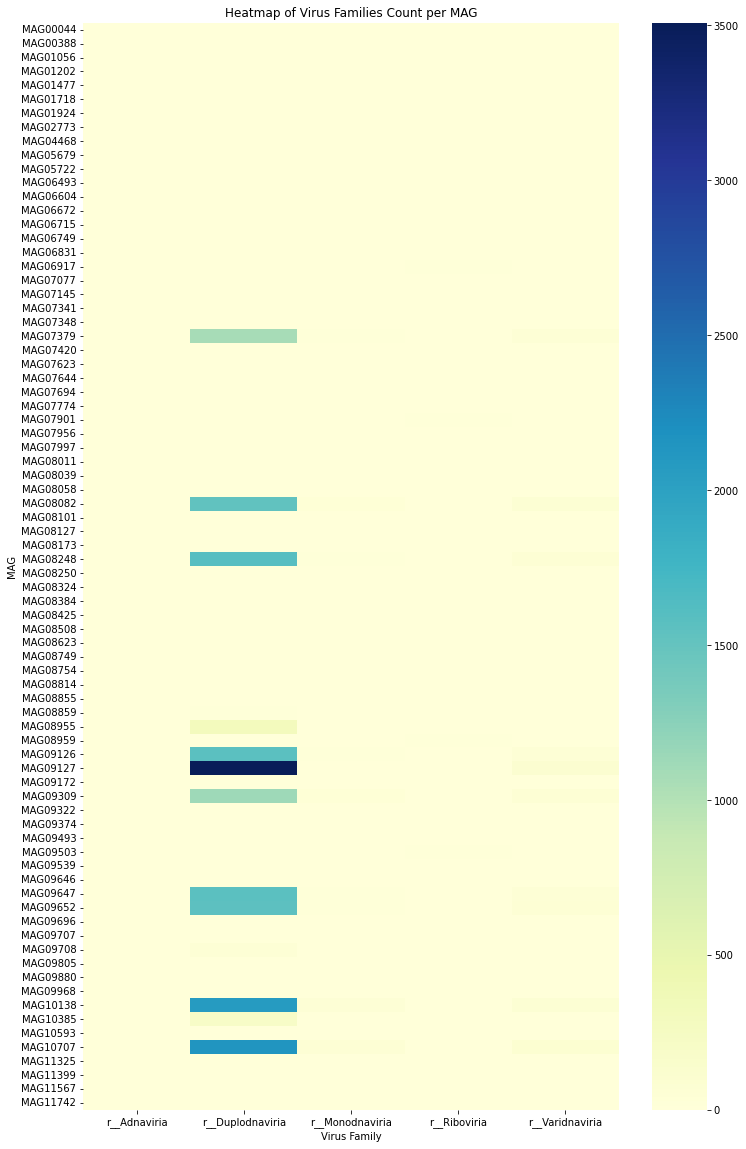

In [61]:
# if I want to count every protein 
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a pivot table with 'MAG' as rows and virus families as columns
heatmap_data = top_hits.pivot_table(index='MAG', columns='Realm', aggfunc='size', fill_value=0)

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_data, annot=False, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Virus Families Count per MAG")
plt.ylabel("MAG")
plt.xlabel("Virus Family")
plt.show()

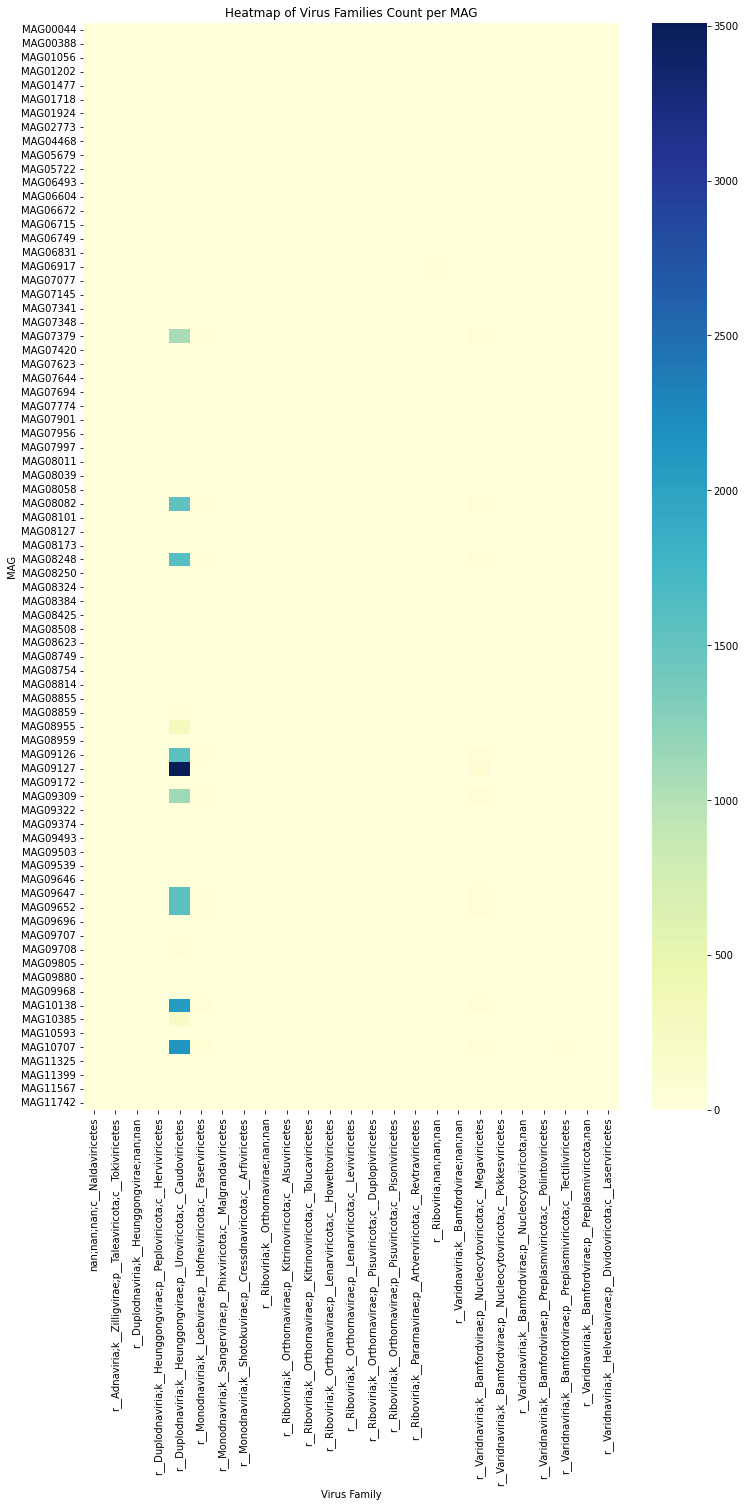

In [125]:
# retrying some the other stuff with copies 
# if I want to count every protein 
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a pivot table with 'MAG' as rows and virus families as columns
heatmap_data = subset.pivot_table(index='MAG', columns='taxonomy', aggfunc='size', fill_value=0)
# Step 2: Plot the heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_data, annot=False, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Virus Families Count per MAG")
plt.ylabel("MAG")
plt.xlabel("Virus Family")
plt.show()



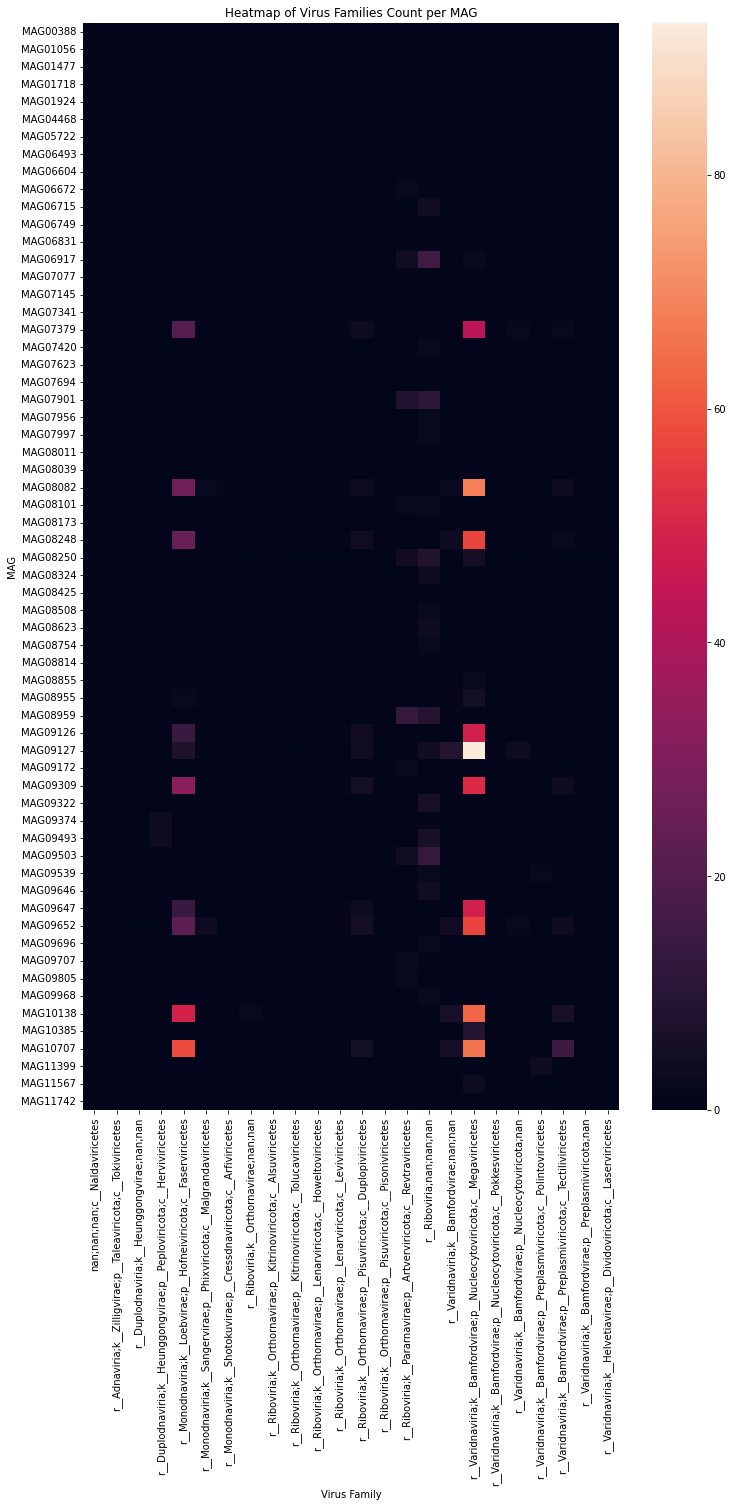

In [127]:
# doing this without that one super high signal
value_to_drop = 'r__Duplodnaviria;k__Heunggongvirae;p__Uroviricota;c__Caudoviricetes'

# Drop rows where the 'taxonomy' column has the specific value
df_cleaned = subset[subset['taxonomy'] != value_to_drop]

heatmap_data = df_cleaned.pivot_table(index='MAG', columns='taxonomy', aggfunc='size', fill_value=0)
# Step 2: Plot the heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_data, annot=False, fmt="d")
plt.title("Heatmap of Virus Families Count per MAG")
plt.ylabel("MAG")
plt.xlabel("Virus Family")
plt.show()


# Presence Absence Analysis

/var/folders/s1/31gd39_55zgcmsjz0xx9m46c0000gn/T/ipykernel_41522/1725306805.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(count_matrix_transposed.columns, rotation=90)  # Rotate x-axis labels for better readability


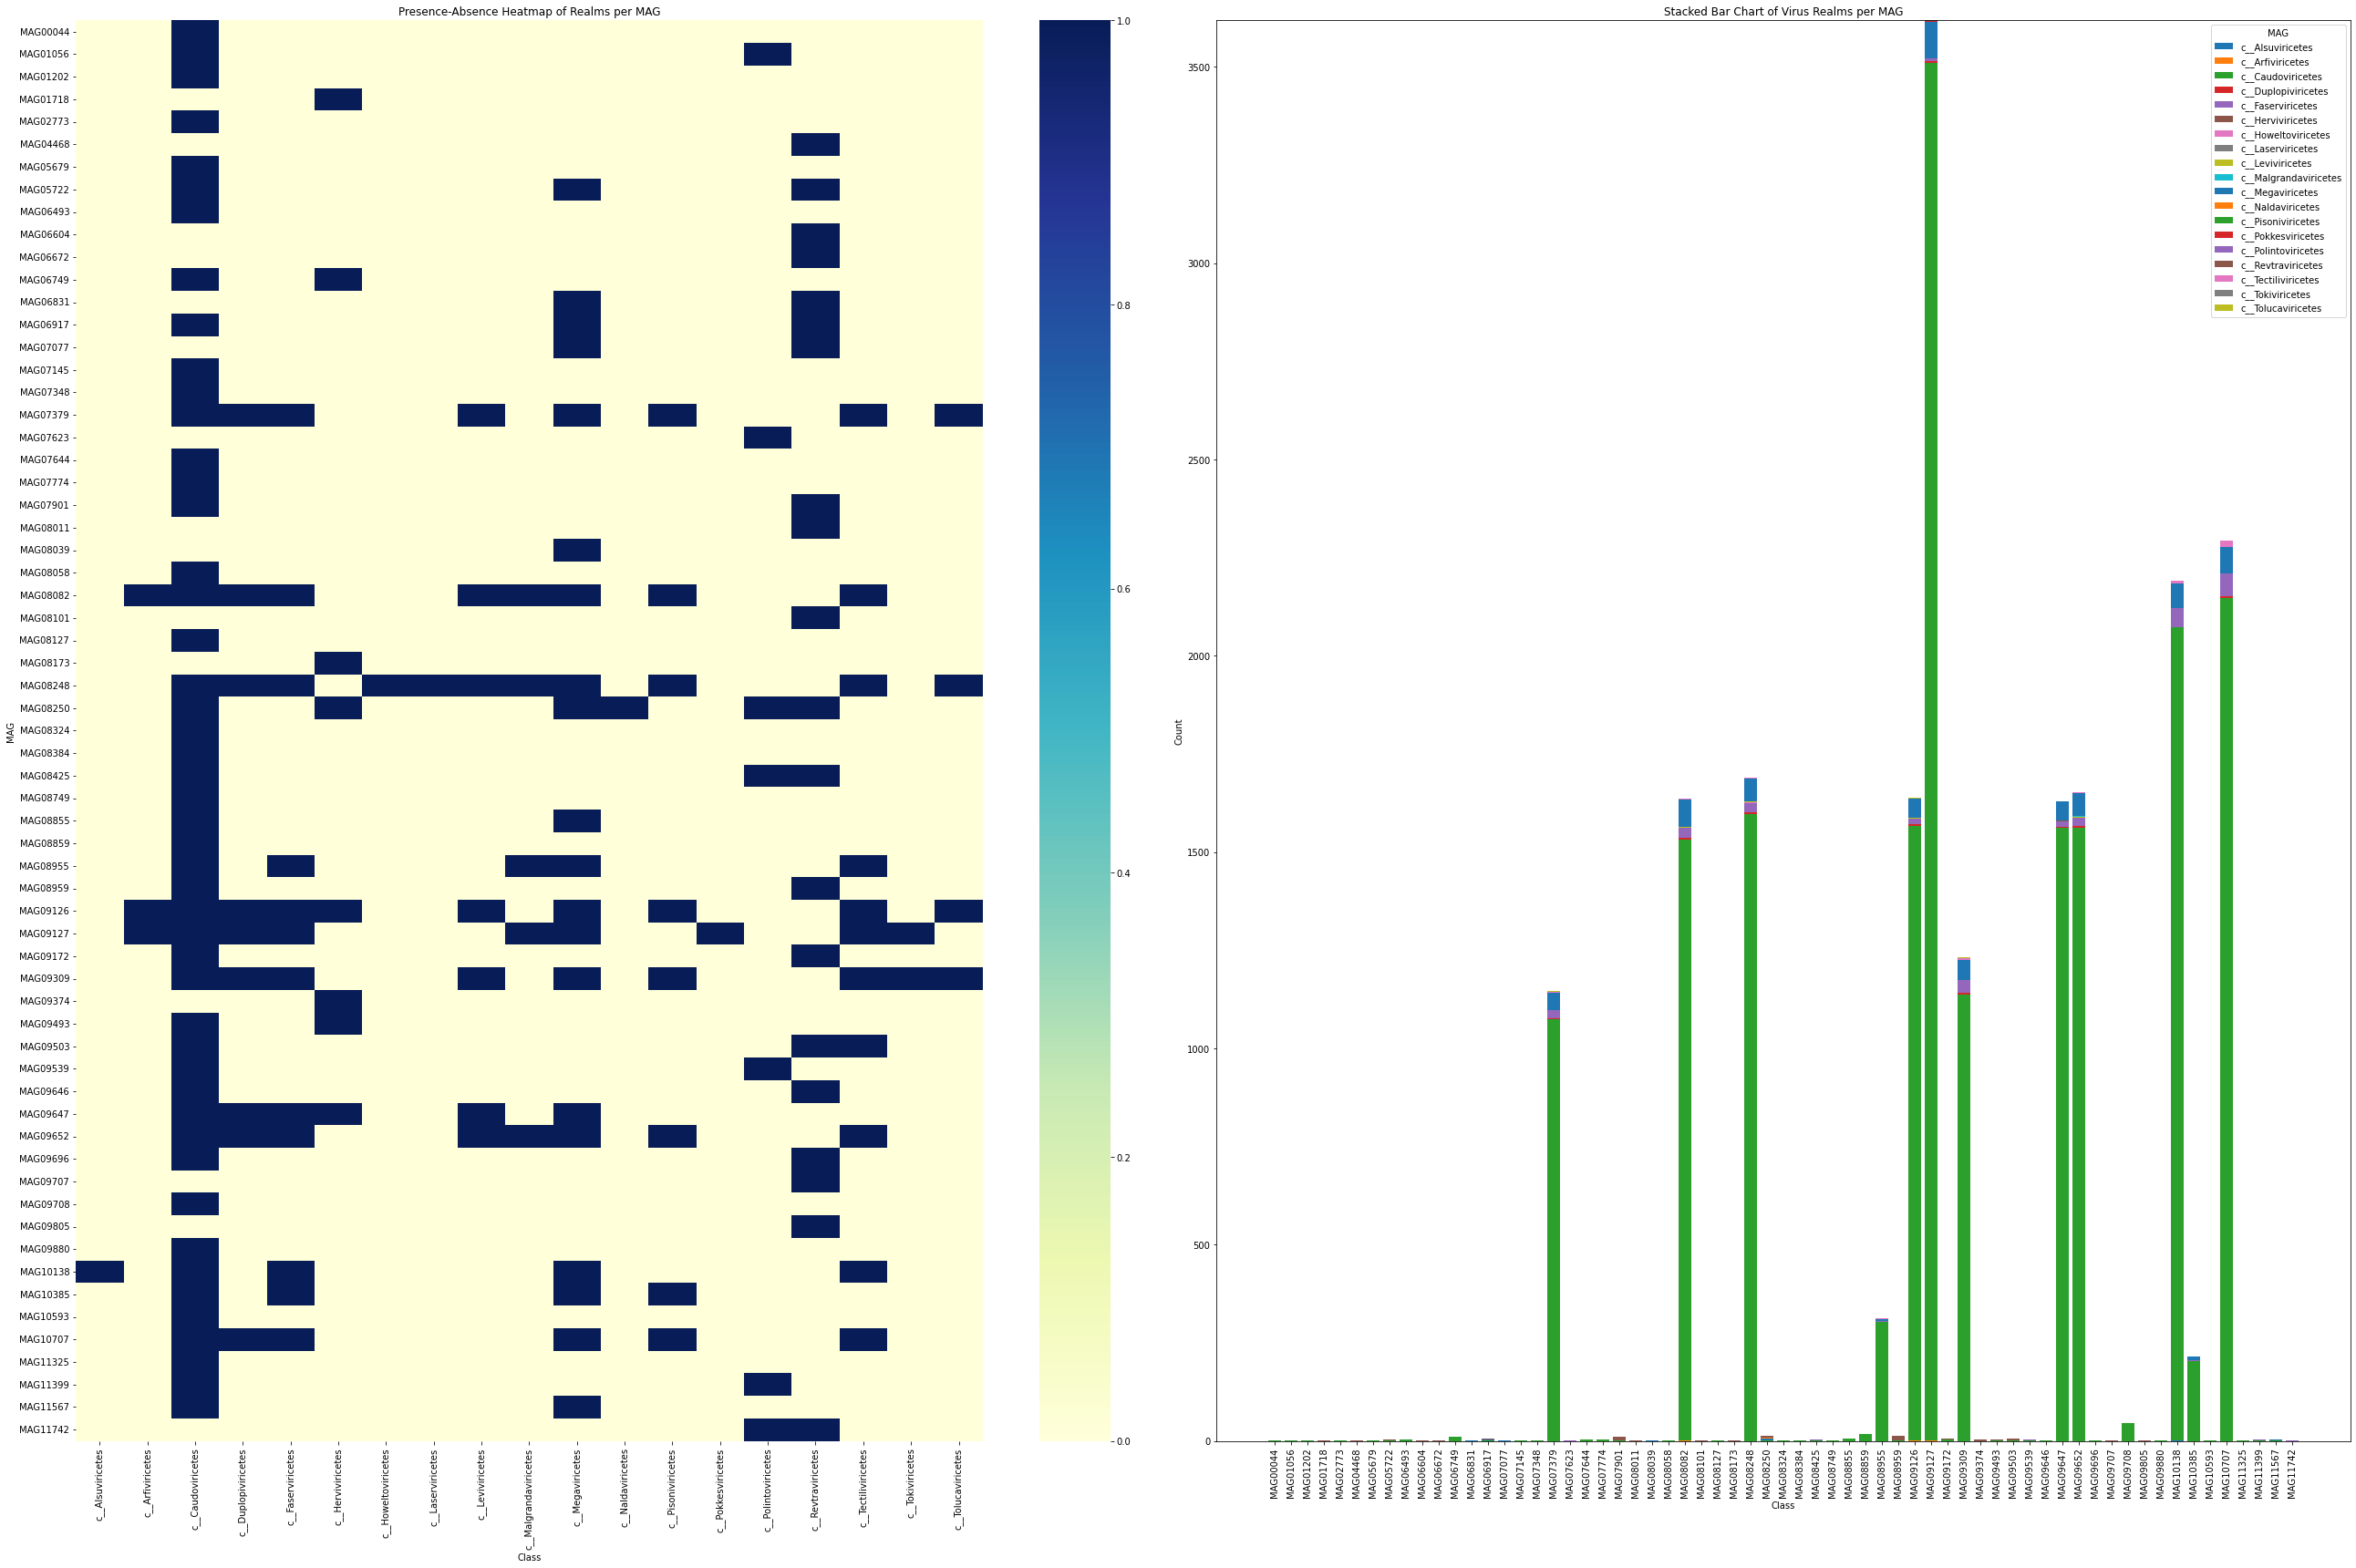

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'subset' is your DataFrame with columns 'Realm' and 'MAG'

subset = top_hits[['Class', 'MAG']]


# Step 1: Create the presence-absence matrix
presence_absence_matrix = subset.pivot_table(index='MAG', columns='Class', aggfunc=lambda x: 1, fill_value=0)

# Step 2: Create a count matrix with counts of each 'Realm' in each 'MAG'
count_matrix = subset.pivot_table(index='MAG', columns='Class', aggfunc='size', fill_value=0)
count_matrix_transposed = count_matrix.T

# Create a combined plot with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 24))

# Plot 1: Heatmap of Presence-Absence
sns.heatmap(presence_absence_matrix, annot=False, fmt="d", cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Presence-Absence Heatmap of Realms per MAG")
axes[0].set_ylabel("MAG")
axes[0].set_xlabel("Class")

# Plot 2: Stacked Bar Chart of Counts
# Define the bottom position for stacking (initialize as zeros)
bottom = [0] * len(count_matrix_transposed.columns)

# Loop through each MAG and plot a bar, stacking each subsequent MAG on top of the previous one
for mag in count_matrix_transposed.index:
    axes[1].bar(count_matrix_transposed.columns, 
                count_matrix_transposed.loc[mag], 
                bottom=bottom, 
                label=mag)
    
    # Update the bottom position to stack the next bar on top
    bottom = bottom + count_matrix_transposed.loc[mag].values

# Add plot labels and title for the stacked bar chart
axes[1].set_title("Stacked Bar Chart of Virus Realms per MAG")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Class")
axes[1].legend(title="MAG")
axes[1].set_xticklabels(count_matrix_transposed.columns, rotation=90)  # Rotate x-axis labels for better readability

# Adjust layout to make sure everything fits nicely
plt.tight_layout()
plt.savefig('SCTLD_viral_class.pdf')
plt.show()


In [109]:
# check which taxonomic level has the most classificiation in virus. Compare between NA and any hit 
# remember here we are doing the reverse. We are calculating %NA
#top_hits 
Realm = top_hits['Realm'].isna().mean() * 100
kingdom = top_hits['Kingdom'].isna().mean() * 100
Phylum = top_hits['Phykum'].isna().mean() * 100
Class = top_hits['Class'].isna().mean() * 100
Order = top_hits['Order'].isna().mean() * 100
Species = top_hits['species'].isna().mean() * 100


print(f"Percentage of NA values in 'Realm' column: {Realm:.2f}%")
print(f"Percentage of NA values in 'Kingdom' column: {kingdom:.2f}%")
print(f"Percentage of NA values in 'Phylum' column: {Phylum:.2f}%")
print(f"Percentage of NA values in 'Class' column: {Class:.2f}%")
print(f"Percentage of NA values in 'Order' column: {Order:.2f}%")
print(f"Percentage of NA values in 'Species' column: {Species:.2f}%")

Percentage of NA values in 'Realm' column: 5.46%
Percentage of NA values in 'Kingdom' column: 6.05%
Percentage of NA values in 'Phylum' column: 6.23%
Percentage of NA values in 'Class' column: 6.30%
Percentage of NA values in 'Order' column: 96.22%
Percentage of NA values in 'Species' column: 99.82%


In [118]:
subset = top_hits[['Realm', 'Kingdom', 'Phykum', 'Class', 'MAG']]

# List the columns you want to merge
columns_to_merge = ['Realm', 'Kingdom', 'Phykum', 'Class']  # Replace with your actual column names

# Create a new column by merging specified columns with ';' as a separator
subset['taxonomy'] = subset[columns_to_merge].apply(lambda row: ';'.join(row.values.astype(str)), axis=1)

# Display the updated DataFrame
subset = subset[subset['taxonomy'] != 'nan;nan;nan;nan']
unique_count = subset['taxonomy'].nunique()
unique_count
# need to look into MAGs that are NAN. 

/var/folders/s1/31gd39_55zgcmsjz0xx9m46c0000gn/T/ipykernel_41522/1165050427.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['taxonomy'] = subset[columns_to_merge].apply(lambda row: ';'.join(row.values.astype(str)), axis=1)


25

/var/folders/s1/31gd39_55zgcmsjz0xx9m46c0000gn/T/ipykernel_41522/2035625010.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(count_matrix_transposed.columns, rotation=90)  # Rotate x-axis labels for better readability


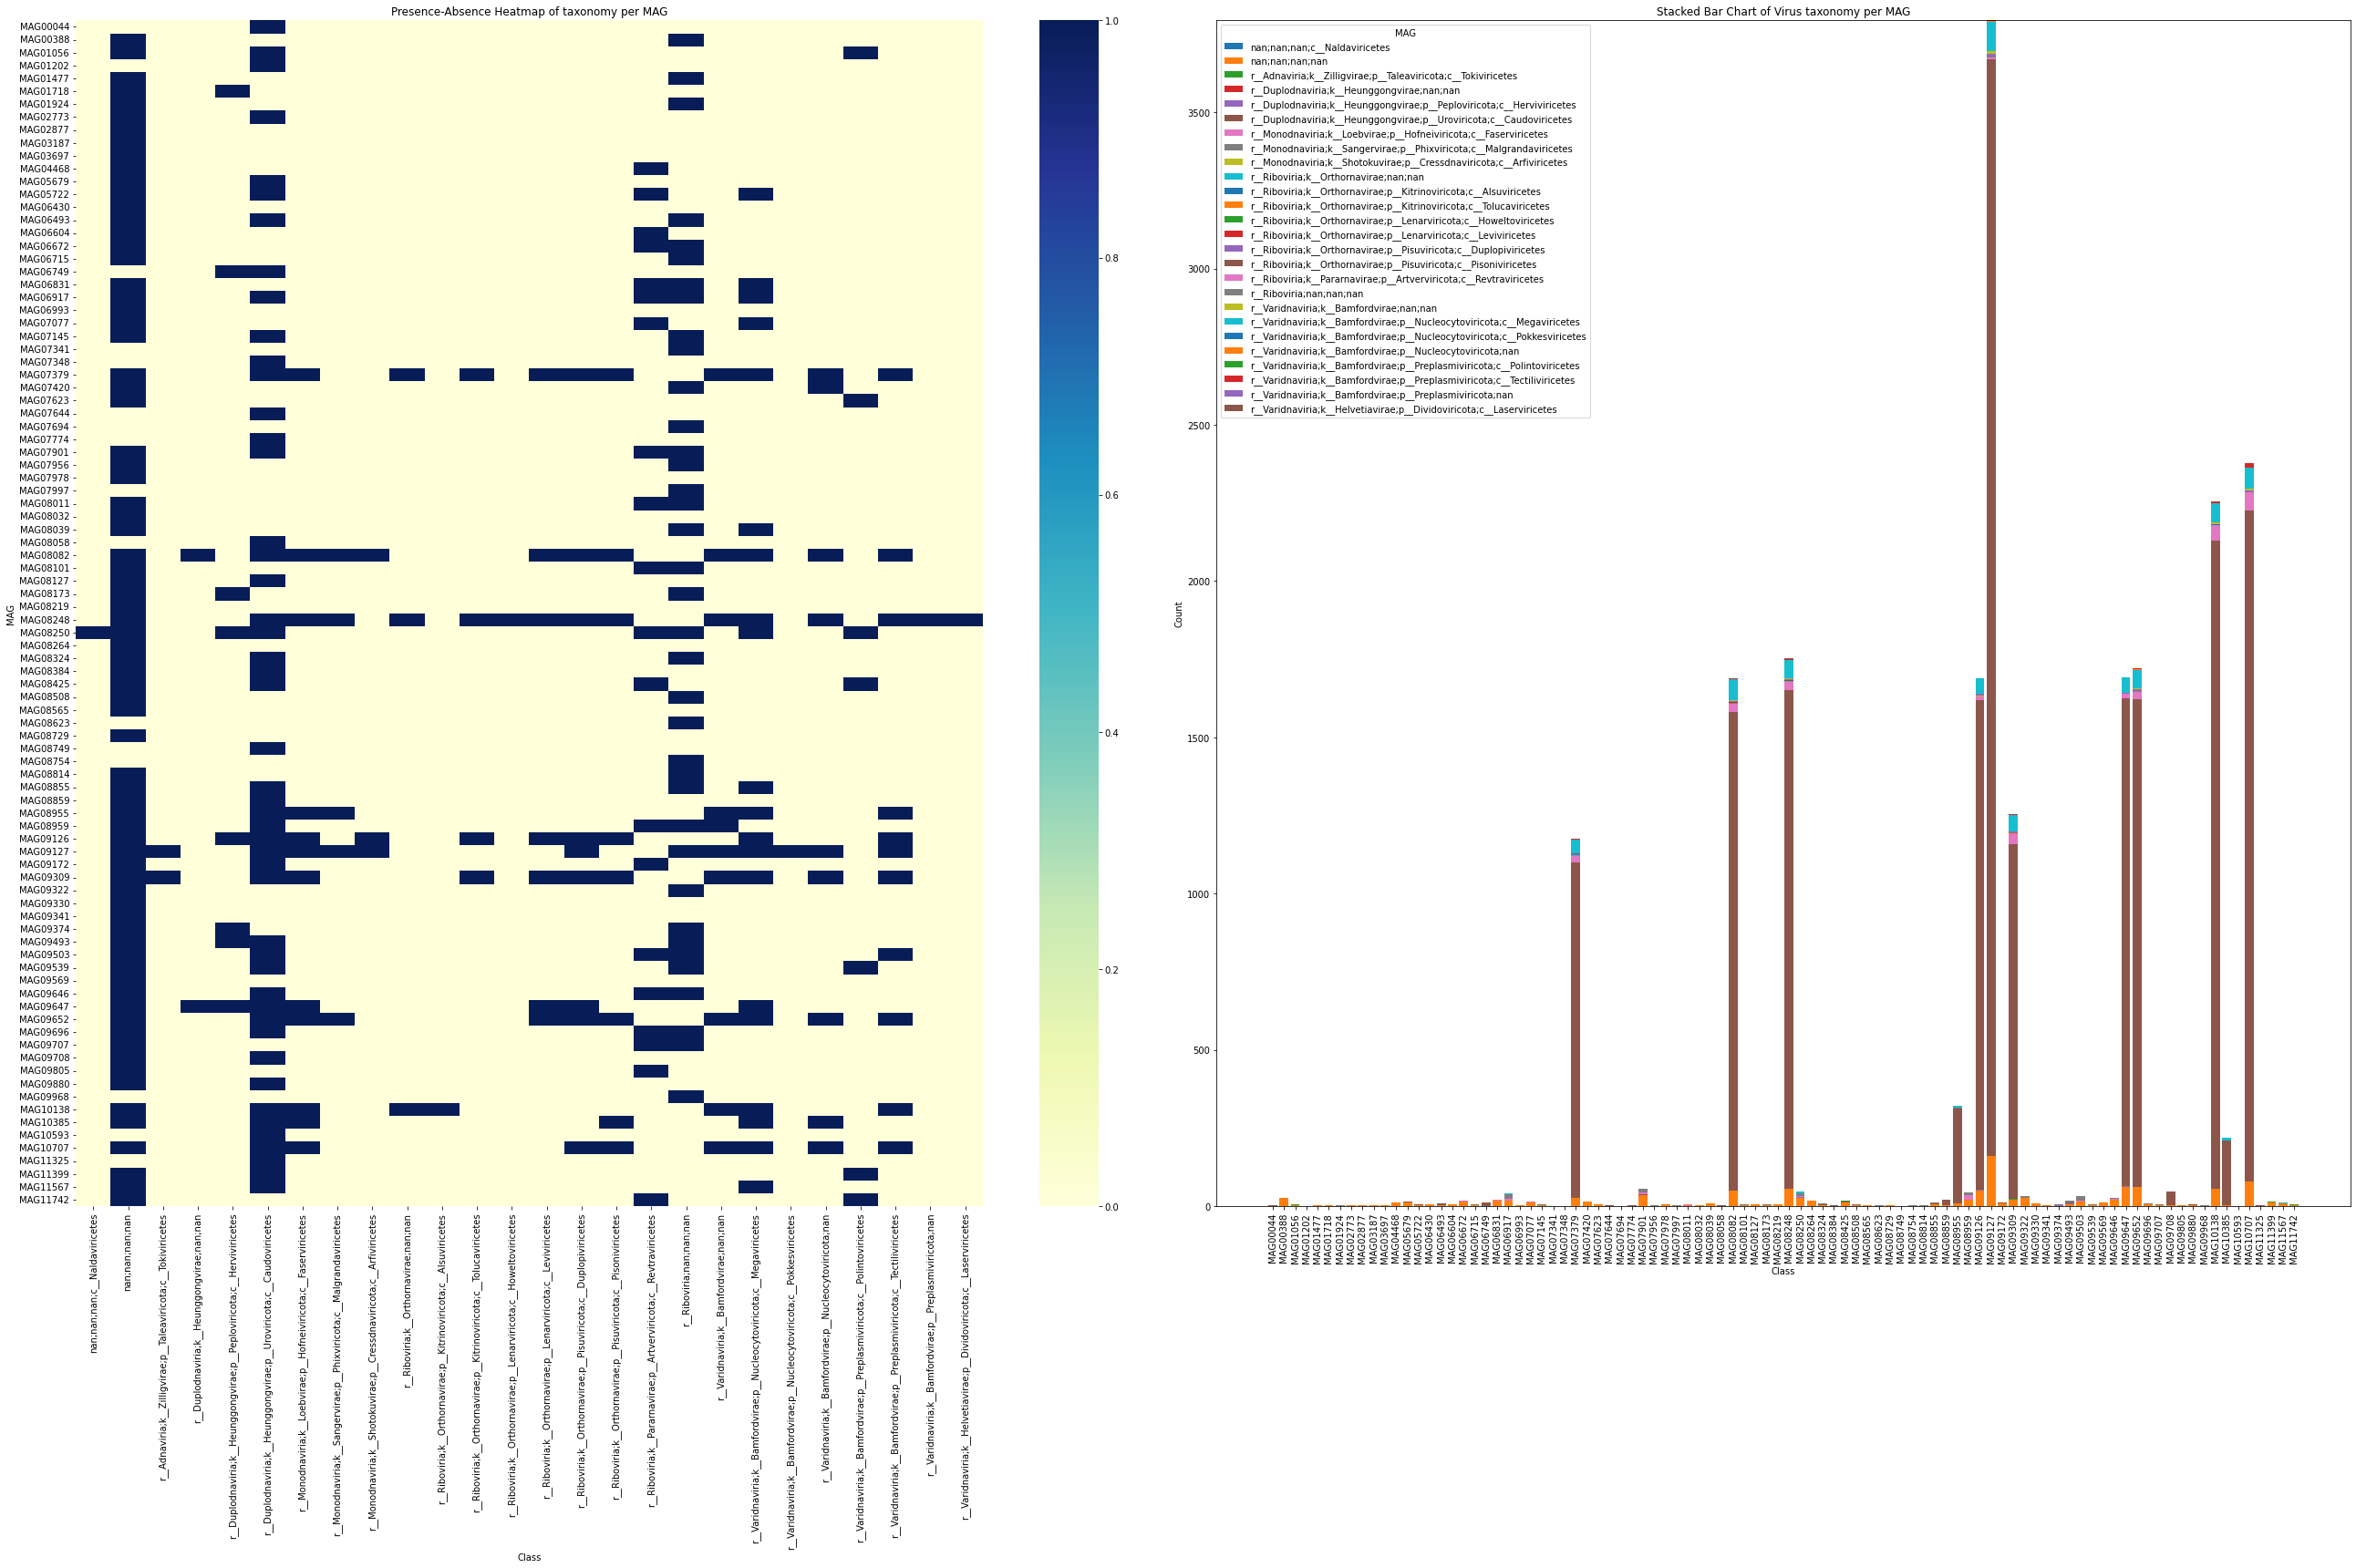

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

subset = subset[['taxonomy', 'MAG']]


# Step 1: Create the presence-absence matrix
presence_absence_matrix = subset.pivot_table(index='MAG', columns='taxonomy', aggfunc=lambda x: 1, fill_value=0)

# Step 2: Create a count matrix with counts of each 'Realm' in each 'MAG'
count_matrix = subset.pivot_table(index='MAG', columns='taxonomy', aggfunc='size', fill_value=0)
count_matrix_transposed = count_matrix.T

# Create a combined plot with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 24))

# Plot 1: Heatmap of Presence-Absence
sns.heatmap(presence_absence_matrix, annot=False, fmt="d", cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Presence-Absence Heatmap of taxonomy per MAG")
axes[0].set_ylabel("MAG")
axes[0].set_xlabel("Class")

# Plot 2: Stacked Bar Chart of Counts
# Define the bottom position for stacking (initialize as zeros)
bottom = [0] * len(count_matrix_transposed.columns)

# Loop through each MAG and plot a bar, stacking each subsequent MAG on top of the previous one
for mag in count_matrix_transposed.index:
    axes[1].bar(count_matrix_transposed.columns, 
                count_matrix_transposed.loc[mag], 
                bottom=bottom, 
                label=mag)
    
    # Update the bottom position to stack the next bar on top
    bottom = bottom + count_matrix_transposed.loc[mag].values

# Add plot labels and title for the stacked bar chart
axes[1].set_title("Stacked Bar Chart of Virus taxonomy per MAG")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Class")
axes[1].legend(title="MAG")
axes[1].set_xticklabels(count_matrix_transposed.columns, rotation=90)  # Rotate x-axis labels for better readability

# Adjust layout to make sure everything fits nicely
plt.tight_layout()
plt.savefig('SCTLDnan_viral_taxonomy.pdf')
plt.show()


**Unnanotated bins**

In [139]:
subset = top_hits[['Realm', 'Kingdom', 'Phykum', 'Class', 'MAG']]

# List the columns you want to merge
columns_to_merge = ['Realm', 'Kingdom', 'Phykum', 'Class']  # Replace with your actual column names

# Create a new column by merging specified columns with ';' as a separator
subset['taxonomy'] = subset[columns_to_merge].apply(lambda row: ';'.join(row.values.astype(str)), axis=1)
unannotated = subset[subset['taxonomy']=="nan;nan;nan;nan"]
unique_count = unannotated['MAG'].nunique()
unique_count

/var/folders/s1/31gd39_55zgcmsjz0xx9m46c0000gn/T/ipykernel_41522/2290181343.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['taxonomy'] = subset[columns_to_merge].apply(lambda row: ';'.join(row.values.astype(str)), axis=1)


76

In [145]:
# Define the threshold for majority presence (80%)
# Function to calculate the percentage of rows with the most common taxonomy value
def majority_taxonomy(group):
    # Get the most common taxonomy value and its frequency
    most_common_value = group['taxonomy'].mode()[0]  # Most frequent value in 'taxonomy'
    count_of_common = (group['taxonomy'] == most_common_value).sum()  # Count of the most frequent value
    
    # Calculate the percentage of rows with the most common taxonomy value
    percentage_common = count_of_common / len(group)
    
    # Return the percentage along with the MAG and the most common taxonomy
    return pd.Series({
        'MAG': group['MAG'].iloc[0], 
        'taxonomy': most_common_value, 
        'percentage': percentage_common * 100  # Convert to percentage
    })

# Apply the function to each group of 'MAG'
new_df = subset.groupby('MAG').apply(majority_taxonomy).reset_index(drop=True)

# Display the resulting new DataFrame
new_df.to_csv("viral_MAG_taxonomy.csv")


# Host Analysis 
Look for viral and host correlation as well


### Correlation
Maybe worth doing a correlation analysis between family of virus and the infected host. 
Or atleast worth a heath map

/var/folders/s1/31gd39_55zgcmsjz0xx9m46c0000gn/T/ipykernel_41522/2069964108.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(count_matrix_transposed.columns, rotation=90)  # Rotate x-axis labels for better readability


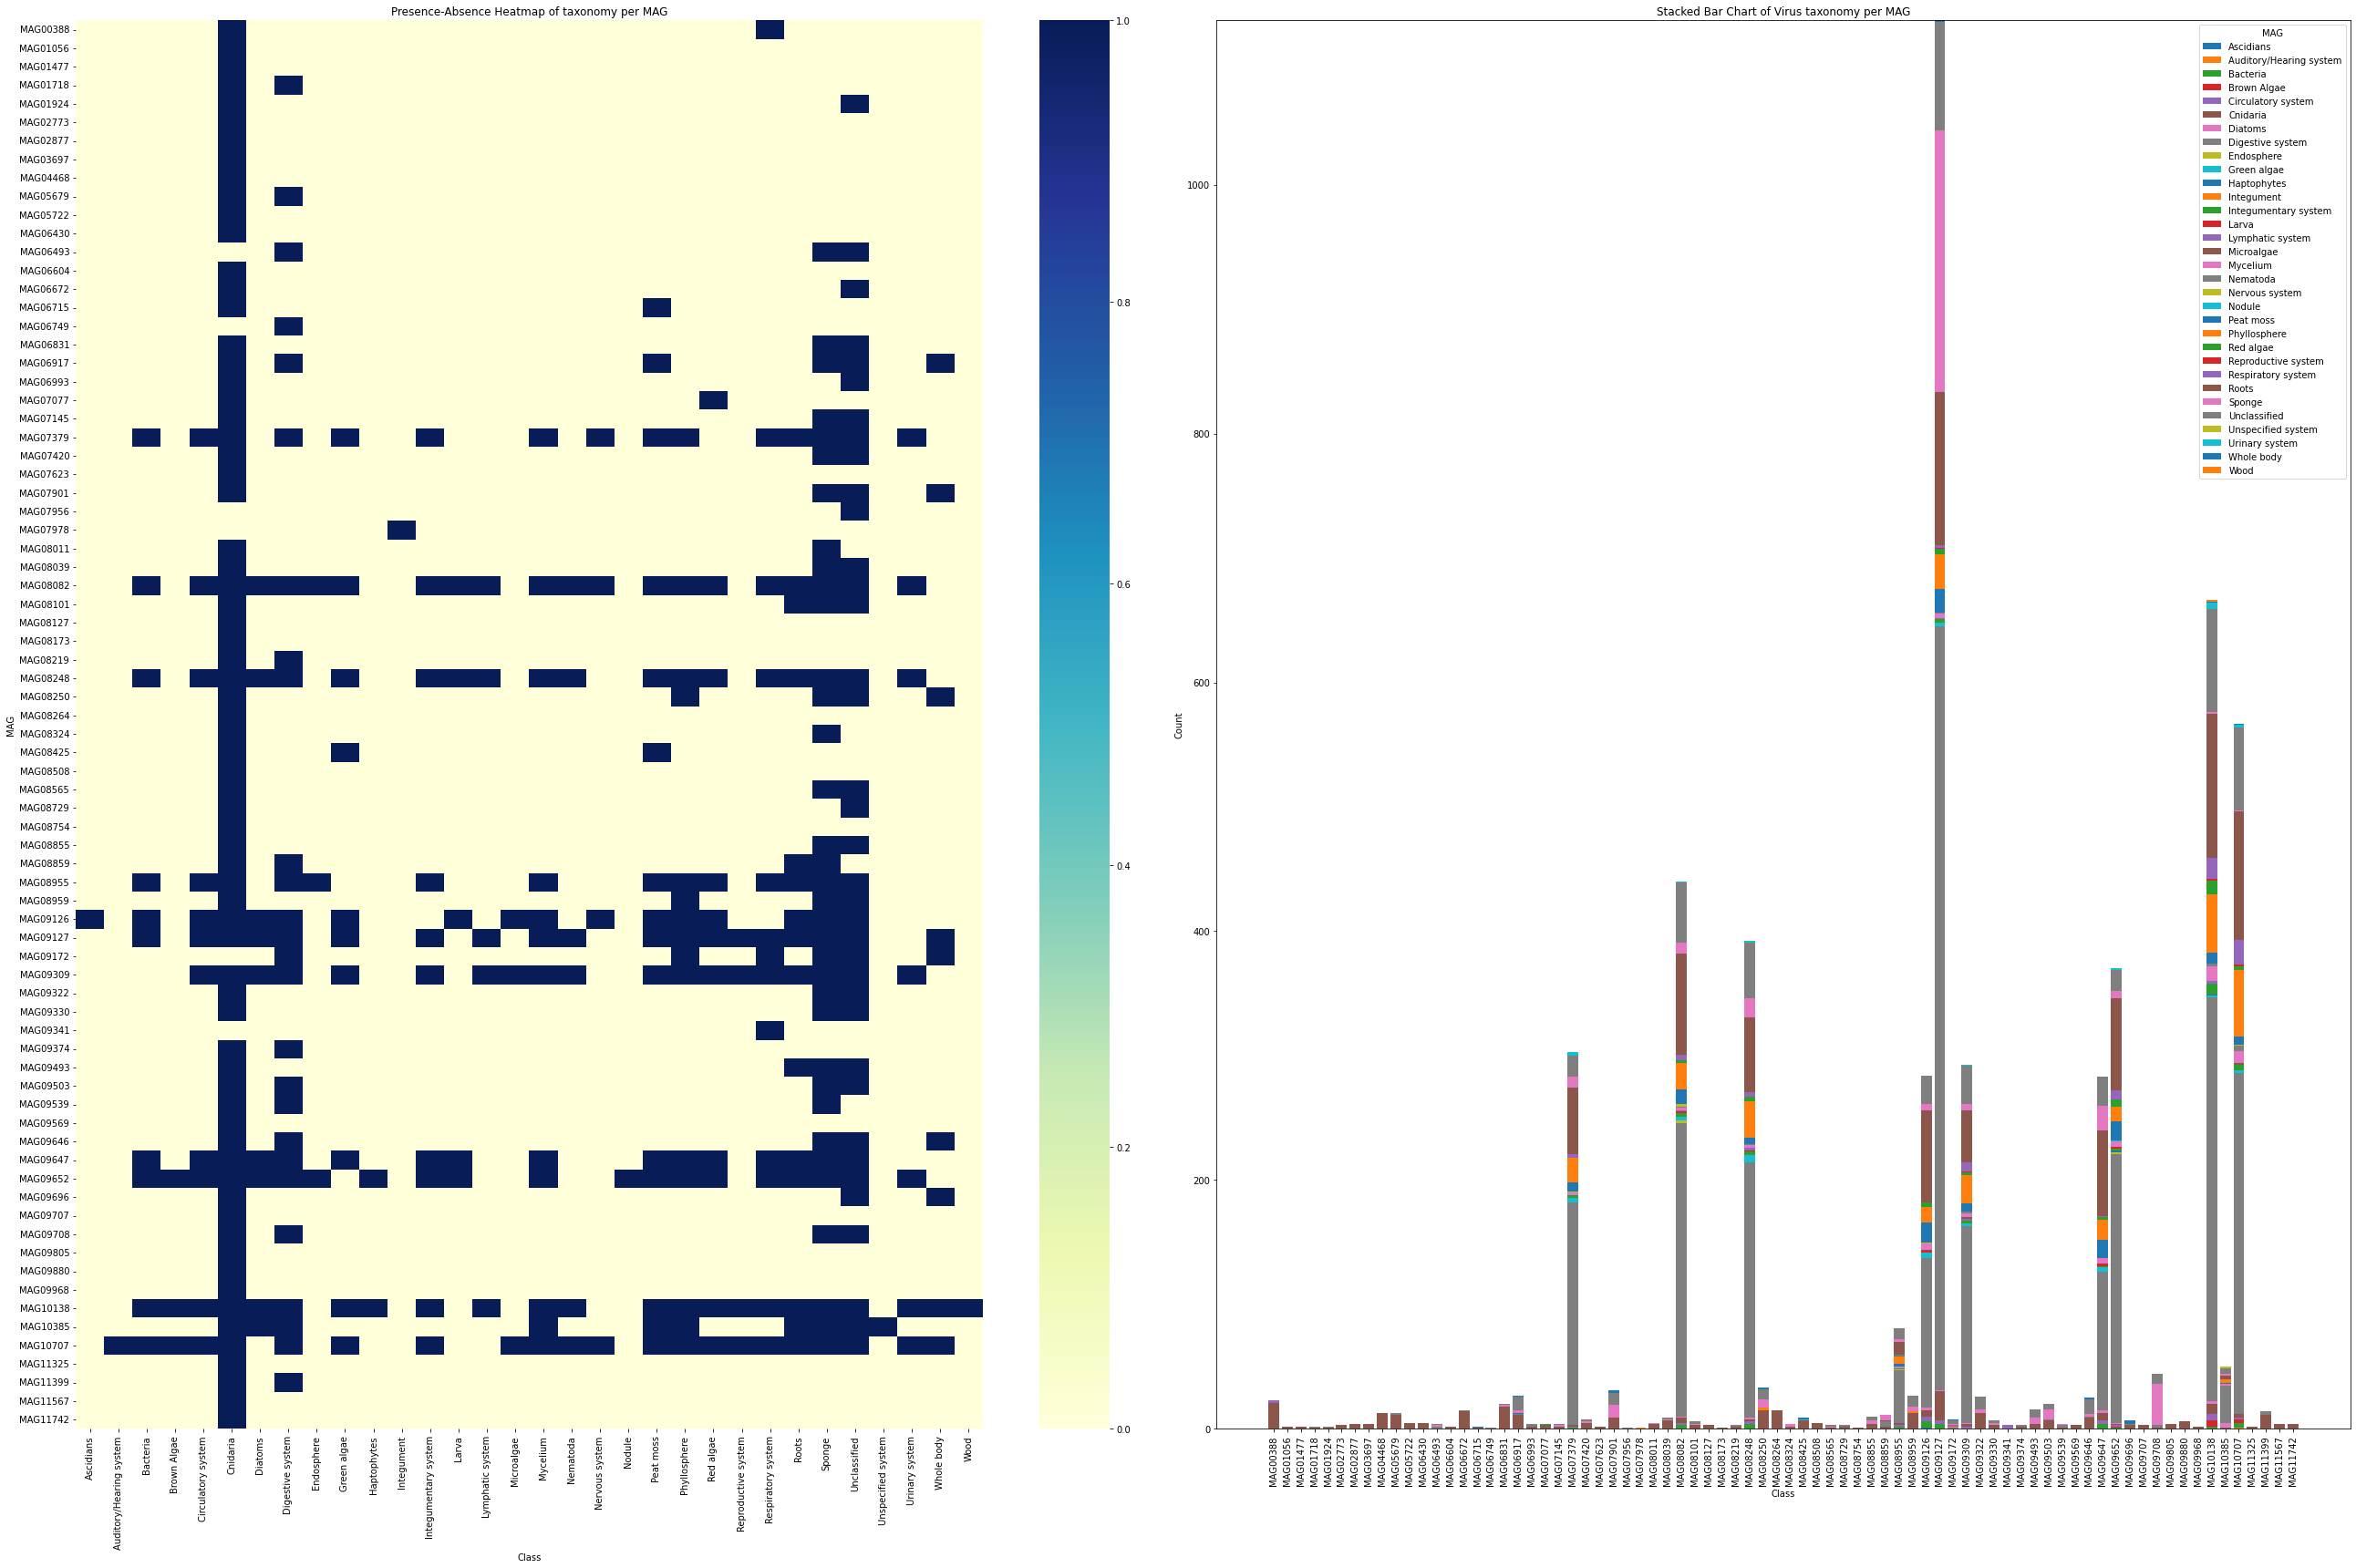

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


host_associated = top_hits[top_hits['Eco_class_I'] == "Host-associated"]

subset = host_associated[['Eco_class_3', 'MAG']]

# Step 1: Create the presence-absence matrix
presence_absence_matrix = subset.pivot_table(index='MAG', columns='Eco_class_3', aggfunc=lambda x: 1, fill_value=0)

# Step 2: Create a count matrix with counts of each 'Realm' in each 'MAG'
count_matrix = subset.pivot_table(index='MAG', columns='Eco_class_3', aggfunc='size', fill_value=0)
count_matrix_transposed = count_matrix.T

# Create a combined plot with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 24))

# Plot 1: Heatmap of Presence-Absence
sns.heatmap(presence_absence_matrix, annot=False, fmt="d", cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Presence-Absence Heatmap of taxonomy per MAG")
axes[0].set_ylabel("MAG")
axes[0].set_xlabel("Class")

# Plot 2: Stacked Bar Chart of Counts
# Define the bottom position for stacking (initialize as zeros)
bottom = [0] * len(count_matrix_transposed.columns)

# Loop through each MAG and plot a bar, stacking each subsequent MAG on top of the previous one
for mag in count_matrix_transposed.index:
    axes[1].bar(count_matrix_transposed.columns, 
                count_matrix_transposed.loc[mag], 
                bottom=bottom, 
                label=mag)
    
    # Update the bottom position to stack the next bar on top
    bottom = bottom + count_matrix_transposed.loc[mag].values

# Add plot labels and title for the stacked bar chart
axes[1].set_title("Stacked Bar Chart of Virus taxonomy per MAG")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Class")
axes[1].legend(title="MAG")
axes[1].set_xticklabels(count_matrix_transposed.columns, rotation=90)  # Rotate x-axis labels for better readability

# Adjust layout to make sure everything fits nicely
plt.tight_layout()
plt.savefig('SCTLD_host_associated_taxonomy.pdf')
plt.show()


In [169]:
def majority_taxonomy(group):
    # Get the most common taxonomy value and its frequency
    most_common_value = group['Eco_class_3'].mode()[0]  # Most frequent value in 'taxonomy'
    count_of_common = (group['Eco_class_3'] == most_common_value).sum()  # Count of the most frequent value
    
    # Calculate the percentage of rows with the most common taxonomy value
    percentage_common = count_of_common / len(group)
    
    # Return the percentage along with the MAG and the most common taxonomy
    return pd.Series({
        'MAG': group['MAG'].iloc[0], 
        'Eco_class_3': most_common_value, 
        'percentage': percentage_common * 100  # Convert to percentage
    })

# Apply the function to each group of 'MAG'
new_df = top_hits.groupby('MAG').apply(majority_taxonomy).reset_index(drop=True)
new_df.to_csv('Host_taxa_per_mag.csv')

# Host analysis continued (4/11) 
However it is important to note that a lot of these hosts have been identified using the limited imgvr database. To get a more accurate understanding of what we have we need to look at the nr database. And see what the genes otherwise annoate to. 

Pipeline overview, 
1. within each protein look at the top 5 hits. and see what the top phylum is. select a representative for each proteins
2. now withint each MAG look at the top5 hits in each protein and select the most commonly occuring phylum. 
3. This final MAG output is then selected as our sub species 

In [15]:
df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/all_mag_nr_output.tsv', sep ='\t')


In [4]:
import pandas as pd 

df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/all_mag_nr_output.tsv', sep ='\t')

# Function to select the row with the highest bitscore, and if tied, choose the one with the highest pid
def select_top_hit(group):
    # Sort by 'bitsscore' in descending order first, then by 'pid' in descending order if bitscore is tied
    group_sorted = group.sort_values(by=['bitscore', 'pid'], ascending=[False, False])
    # Return the first row, which will have the highest bitscore, and highest pid if bitscore is tied
    return group_sorted.iloc[0]

# Group the DataFrame by the first column (assuming it's named 'query') and apply the selection function
top_hits = df.groupby('qseqid', group_keys=False).apply(select_top_hit)

# Display the resulting top hits DataFrame
top_hits = top_hits.drop(columns=['qseqid'])

top_hits = top_hits.reset_index()

top_hits['MAG'] = top_hits['qseqid'].str.split('_').str[0]

In [18]:
# alternate way of selection. 
# select the top 5 hits based on bitscore. now of the subset 5 then look for the most common phylum.
# then generate subset df with the name of the qseqid column and the phylum thereby subsetting the data


# Function to select the top 5 hits based on bitscore, and if tied, use pid to sort
def select_top_5(group):
    # Sort by 'bitscore' in descending order first, then by 'pid' in descending order if bitscore is tied
    group_sorted = group.sort_values(by=['bitscore', 'pid'], ascending=[False, False])
    # Return the top 5 rows
    return group_sorted.head(5)

# Group the DataFrame by 'qseqid' and apply the selection function
top_5_hits = df.groupby('qseqid', group_keys=False).apply(select_top_5)

# Display the resulting top 5 hits DataFrame
top_5_hits

,qseqid,sseqid,pid,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,evalue,bitscore,qlen,slen,function,taxid,species,phylum,subkingdom,kingdom
1,MAG00044_1_1,GIL54183_1,37.0,1011,531,32,820,1773,360,1321,2.140000e-164,548.0,1786,1328,"GIL54183_1 hypothetical protein Vafri_9708, pa...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota
0,MAG00044_1_1,GIL57503_1,36.4,982,542,26,820,1757,48,990,3.940000e-165,541.0,1786,1010,"GIL57503_1 hypothetical protein Vafri_12725, p...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota
2,MAG00044_1_1,GIL51644_1,35.7,1002,561,26,820,1777,126,1088,2.260000e-164,541.0,1786,1088,"GIL51644_1 hypothetical protein Vafri_7587, pa...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota
3,MAG00044_1_1,GIL51657_1,35.7,1002,561,26,820,1777,185,1147,1.020000e-163,541.0,1786,1147,"GIL51657_1 hypothetical protein Vafri_7599, pa...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota
5,MAG00044_1_1,GIL49617_1,36.7,1011,534,32,820,1773,323,1284,3.060000e-161,539.0,1786,1291,GIL49617_1 hypothetical protein Vafri_5892 [Vo...,51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244401,MAG11742_3_4,XP_020630787_1,80.4,97,16,1,1,97,1359,1452,8.220000e-39,148.0,102,3937,XP_020630787_1 E3 ubiquitin-protein ligase rnf...,48498.0,Orbicella faveolata,Cnidaria,Metazoa,Eukaryota
244402,MAG11742_3_4,XP_020630861_1,76.3,97,20,1,1,97,1044,1137,4.000000e-36,140.0,102,1293,XP_020630861_1 E3 ubiquitin-protein ligase RNF...,48498.0,Orbicella faveolata,Cnidaria,Metazoa,Eukaryota
244405,MAG11742_3_4,XP_022796393_1,73.2,97,23,1,1,97,2505,2598,2.330000e-34,135.0,102,5699,XP_022796393_1 E3 ubiquitin-protein ligase rnf...,50429.0,Stylophora pistillata,Cnidaria,Metazoa,Eukaryota
244406,MAG11742_3_4,XP_022796392_1,73.2,97,23,1,1,97,2509,2602,2.330000e-34,135.0,102,5703,XP_022796392_1 E3 ubiquitin-protein ligase rnf...,50429.0,Stylophora pistillata,Cnidaria,Metazoa,Eukaryota


In [24]:
# Step 2: Determine the most common phylum for each qseqid group and add it as a new column
def add_most_common_phylum(group):
    # Find the most common phylum in the group
    most_common_phylum = group['phylum'].mode().iloc[0]
    # Assign the most common phylum to a new column called 'tophit' for all rows in the group
    group['tophit'] = most_common_phylum
    return group

# Apply the function to each group
top_5_hits = top_5_hits.groupby('qseqid', group_keys=False).apply(add_most_common_phylum)

final_hits = top_5_hits.drop_duplicates(subset='qseqid', keep='first').reset_index(drop=True)
final_hits['MAG'] = final_hits['qseqid'].str.split('_').str[0]
final_hits


def add_most_common_phylum(group):
    # Find the most common phylum in the group
    most_common_phylum = group['phylum'].mode().iloc[0]
    # Assign the most common phylum to a new column called 'tophit' for all rows in the group
    group['MAG_based_tophit'] = most_common_phylum
    return group

# now check if hits in a MAG are the same and select the top hit 
MAG_filtering = final_hits.groupby('MAG', group_keys=False).apply(add_most_common_phylum)
MAG_filtering

,qseqid,sseqid,pid,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,slen,function,taxid,species,phylum,subkingdom,kingdom,tophit,MAG,MAG_based_tophit
0,MAG00044_1_1,GIL54183_1,37.0,1011,531,32,820,1773,360,1321,...,1328,"GIL54183_1 hypothetical protein Vafri_9708, pa...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota,Chlorophyta,MAG00044,Chlorophyta
1,MAG00044_2_1,GIL57503_1,36.8,971,553,24,657,1594,48,990,...,1010,"GIL57503_1 hypothetical protein Vafri_12725, p...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota,Chlorophyta,MAG00044,Chlorophyta
2,MAG00388_10_1,XP_020614733_1,74.9,2501,611,8,1,2493,1639,4130,...,4218,"XP_020614733_1 sacsin-like, partial [Orbicella...",48498.0,Orbicella faveolata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG00388,Cnidaria
3,MAG00388_1_1,PFX28327_1,50.4,113,52,1,1,109,1,113,...,485,PFX28327_1 hypothetical protein AWC38_SpisGene...,50429.0,Stylophora pistillata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG00388,Cnidaria
4,MAG00388_1_2,XP_020615977_1,86.2,298,41,0,2,299,184,481,...,656,XP_020615977_1 uncharacterized protein LOC1100...,48498.0,Orbicella faveolata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG00388,Cnidaria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,MAG11742_2_5,XP_028415017_1,70.8,65,19,0,1,65,120,184,...,832,XP_028415017_1 uncharacterized protein K02A2.6...,151771.0,Dendronephthya gigantea,Cnidaria,Metazoa,Eukaryota,Proteobacteria,MAG11742,Cnidaria
25016,MAG11742_2_6,XP_002740782_1,61.4,267,80,2,1,244,315,581,...,1320,XP_002740782_1 PREDICTED: uncharacterized prot...,10224.0,Saccoglossus kowalevskii,Hemichordata,Metazoa,Eukaryota,Cnidaria,MAG11742,Cnidaria
25017,MAG11742_2_7,XP_044169620_1,80.0,70,14,0,3,72,85,154,...,271,XP_044169620_1 uncharacterized protein LOC1229...,45264.0,Acropora millepora,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG11742,Cnidaria
25018,MAG11742_3_2,XP_022801884_1,82.1,39,7,0,18,56,3186,3224,...,5519,XP_022801884_1 E3 ubiquitin-protein ligase rnf...,50429.0,Stylophora pistillata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG11742,Cnidaria


In [27]:
# remove bacteriphages 
remove_mag_values = [
    "MAG06917", "MAG07379", "MAG08082", "MAG08248", "MAG08955", "MAG09126", "MAG09127", 
    "MAG09309", "MAG09647", "MAG09652", "MAG10385", "MAG11567", "MAG10138", "MAG10707", 
    "MAG10792", "MAG00999", "MAG01253", "MAG03669", "MAG05933", "MAG06662", "MAG06679", 
    "MAG06832", "MAG07484", "MAG07602", "MAG07903", "MAG08134", "MAG08251", "MAG08787", 
    "MAG00490", "MAG00729", "MAG02656", "MAG03195", "MAG08872", "MAG09812", "MAG02542", 
    "MAG11662", "MAG00014", "MAG04026", "MAG05610", "MAG06911", "MAG08156", "MAG04217", "MAG06025"
]

# Filter the dataframe to remove rows with any of these MAG values
MAG_filtering = MAG_filtering[~MAG_filtering['MAG'].isin(remove_mag_values)]
MAG_filtering

,qseqid,sseqid,pid,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,slen,function,taxid,species,phylum,subkingdom,kingdom,tophit,MAG,MAG_based_tophit
0,MAG00044_1_1,GIL54183_1,37.0,1011,531,32,820,1773,360,1321,...,1328,"GIL54183_1 hypothetical protein Vafri_9708, pa...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota,Chlorophyta,MAG00044,Chlorophyta
1,MAG00044_2_1,GIL57503_1,36.8,971,553,24,657,1594,48,990,...,1010,"GIL57503_1 hypothetical protein Vafri_12725, p...",51714.0,Volvox africanus,Chlorophyta,Viridiplantae,Eukaryota,Chlorophyta,MAG00044,Chlorophyta
2,MAG00388_10_1,XP_020614733_1,74.9,2501,611,8,1,2493,1639,4130,...,4218,"XP_020614733_1 sacsin-like, partial [Orbicella...",48498.0,Orbicella faveolata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG00388,Cnidaria
3,MAG00388_1_1,PFX28327_1,50.4,113,52,1,1,109,1,113,...,485,PFX28327_1 hypothetical protein AWC38_SpisGene...,50429.0,Stylophora pistillata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG00388,Cnidaria
4,MAG00388_1_2,XP_020615977_1,86.2,298,41,0,2,299,184,481,...,656,XP_020615977_1 uncharacterized protein LOC1100...,48498.0,Orbicella faveolata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG00388,Cnidaria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,MAG11742_2_5,XP_028415017_1,70.8,65,19,0,1,65,120,184,...,832,XP_028415017_1 uncharacterized protein K02A2.6...,151771.0,Dendronephthya gigantea,Cnidaria,Metazoa,Eukaryota,Proteobacteria,MAG11742,Cnidaria
25016,MAG11742_2_6,XP_002740782_1,61.4,267,80,2,1,244,315,581,...,1320,XP_002740782_1 PREDICTED: uncharacterized prot...,10224.0,Saccoglossus kowalevskii,Hemichordata,Metazoa,Eukaryota,Cnidaria,MAG11742,Cnidaria
25017,MAG11742_2_7,XP_044169620_1,80.0,70,14,0,3,72,85,154,...,271,XP_044169620_1 uncharacterized protein LOC1229...,45264.0,Acropora millepora,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG11742,Cnidaria
25018,MAG11742_3_2,XP_022801884_1,82.1,39,7,0,18,56,3186,3224,...,5519,XP_022801884_1 E3 ubiquitin-protein ligase rnf...,50429.0,Stylophora pistillata,Cnidaria,Metazoa,Eukaryota,Cnidaria,MAG11742,Cnidaria


In [49]:
host_annotation = MAG_filtering[['MAG', 'MAG_based_tophit']]
host_annotation = host_annotation.drop_duplicates(subset='MAG', keep='first').reset_index(drop=True)
host_annotation


,MAG,MAG_based_tophit
0,MAG00044,Chlorophyta
1,MAG00388,Cnidaria
2,MAG01056,Cnidaria
3,MAG01202,Chlorophyta
4,MAG01477,Cnidaria
...,...,...
73,MAG09968,Nematoda
74,MAG10593,Basidiomycota
75,MAG11325,Cnidaria
76,MAG11399,Cnidaria


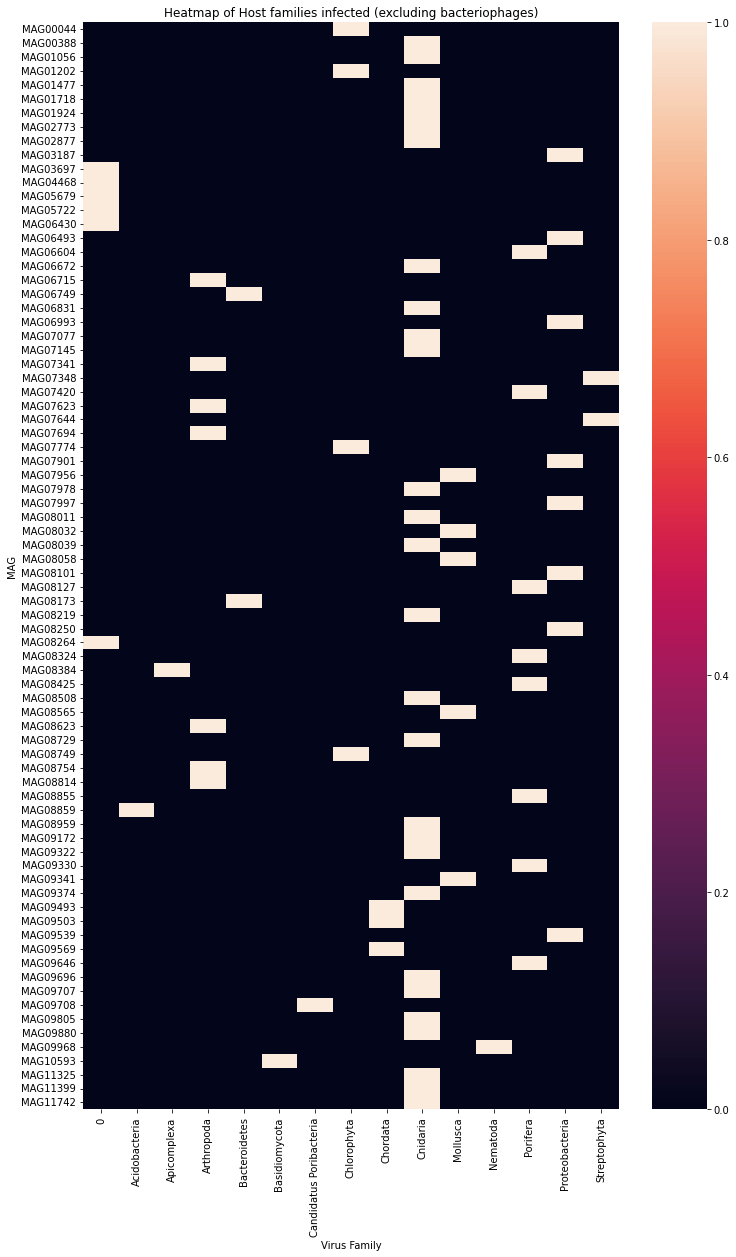

In [36]:
# sure this is causing errors directly since the largest MAGs are infected are proteobacteria. 
# Want to clean that out for non bacteriphages

# Step 1: Create a pivot table with 'MAG' as rows and virus families as columns
heatmap_data = host_annotation.pivot_table(index='MAG', columns='MAG_based_tophit', aggfunc='size', fill_value=0)

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_data, annot=False, fmt="d")
plt.title("Heatmap of Host families infected (excluding bacteriophages)")
plt.ylabel("MAG")
plt.xlabel("Virus Family")
plt.show()

# Host analysis summary 

nr hits obviously made a lot more sense, so that needs to be a golden standard. imgvr hitrs are also definitely worth it. 
Using this data I merge it with the overall SCTLD table. I use this to filter only cnidaria and chordata/chlorophyta hits (assuming here they may be proxy for symbiont bins)

# Candidate MAGs infecting our hosts of interest

All the annotation so far has been used to select MAGs of interest based on disease state (disease specific), viral annoations, and target hosts. 

**Cnidaria MAG** 
MAG07077
MAG07145
MAG08011
MAG08729
MAG08959
MAG09172
MAG09322
MAG09374
MAG09696
MAG09707

**Chordata MAG**
MAG09493
MAG09503
MAG09569

There are also other MAGs that had clear hits to mollusca and arthopoda and blah blah. So I have rule those bins out of this analysis. These could simply jsut be viruses floating around in the water column or an artificat of something living on the coral. 


# Viral trees 

use this tool online for creating tree. ViPTree (KEGG). 

If needed we can also make a tree on terminal using the pipeline attached here https://github.com/shrinivas-nandi/shrinivas-nandi/blob/main/Pipelines/Phylogenetic_tree.sh

# Bacterial MAGs

Some of these MAGs have both high viral and bacterial loads. For that reason, I have included these MAGs in both a viral and bacterial analysis. 

So the goal for bacteria first is gene prediction (prokka) and annotation (gtdbk)

In [ ]:
#gtdbtk

#export db path
#gtdbtk classify_wf --genome_dir /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/bacterial_bins/bacterial_genomes --out_dir /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/bacterial_bins/gtdb_output --cpus 50 --mash_db /scratch/databases/gtdb/R220/

# now merge the output with what we found. 


import pandas as pd

gtdb = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/gtdbtk.bac120.summary.tsv', sep='\t')
# change header user_genome gtdb

gene_info = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/SCTLD_MAG.csv')
gene_info

gtdb = gtdb.rename(columns={'user_genome': 'Genome'})

gtdb = pd.merge(gtdb, gene_info, on="Genome", how="left")
gtdb.to_csv('gtdb_merge.csv')





running virify to use PPR-meta on some of these bacterial MAGs. Goal is to look for any plasmid like MAGs. 
Might also be worth running it on the rest of the stuff.

In [ ]:
# for nr 
/home/timothy/programs/DIAMOND_v2.1.8/bin/diamond blastp --ultra-sensitive --max-target-seqs 10 --evalue 0.00001 --query all_MAG_nr.faa --db /scratch/databases/ncbi/2022_07/nr.dmnd --out all_mag_nr_output.tsv --threads 60 --outfmt 6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen stitle staxids sscinames sphylums skingdoms sskingdoms



In [ ]:
# look at ppr meta data. 
# from each of the run fiels there is a directory. the file of interest is in subdir /01-viruses/pprmeta/*.csv
# copy these files to a new dir 

# Define the destination directory
destination_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/bacterial_bins/ppr_meta"

# Create the destination directory if it doesn't exist
mkdir -p "$destination_dir"

# Find and copy all .csv files from subdirectories
find /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/bacterial_bins/results -type f -path "*/01-viruses/pprmeta/*.csv" -exec cp {} "$destination_dir" \;



There are clear MAGs that are abundant that have a large number of contigs that have top hits to plasmid according to ppr_meta. 
This is interesting and is worth downloading and working with. 

# Gene and Domain Annotation 

In [ ]:
# interpro scan to annotate genes/domains
/home/timothy/programs/my_interproscan/interproscan-5.53-87.0/interproscan.sh --cpu 60 -d /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/interproscan -i /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/interproscan/fasta/MAG06604.fasta

# fcor loops

#!/bin/bash

# Directory containing your FASTA files
input_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/interproscan/"
# InterProScan script path
interproscan_script="/home/timothy/programs/my_interproscan/interproscan-5.53-87.0/interproscan.sh"
# Output directory for the results
output_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/interproscan"

# Create output directory if it doesn't exist
mkdir -p "$output_dir"

# Loop through all fasta files in the input directory
for fasta_file in "$input_dir"/*.faa; do
  # Run InterProScan
  "$interproscan_script" --cpu 60 -d "$output_dir" -i "$fasta_file"
done




#!/bin/bash

# Directory containing your FASTA files
input_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/MAG_orf/viral_MAGs"
# EggNOG-mapper script path
eggnog_mapper="/home/timothy/programs/eggnog-mapper-2.1.6/emapper.py"
# Data directory for EggNOG-mapper
data_dir="/scratch/timothy/databases/eggnog-mapper-rel20211209"
# Output directory for the results
output_dir="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/eggnog-mapper"

# Create output directory if it doesn't exist
mkdir -p "$output_dir"

# Loop through all fasta files in the input directory
for fasta_file in "$input_dir"/*.faa; do
  # Extract the filename without the extension for the output
  filename=$(basename "${fasta_file%.faa}")
  
  # Run EggNOG-mapper
  python "$eggnog_mapper" -i "$fasta_file" --cpu 48 --itype prot -o "$output_dir/$filename" --data_dir "$data_dir"
done



In [ ]:
/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/MAG_viral_contigs

# For Circos Plots

In [ ]:
# gff_extract.sh
# for jsut one file
#!/bin/bash

# Define file paths
GFF_FILE="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/circos_trial/MAG06493_genes.gff"
OUTPUT_FILE="output_sequences_with_gc.tsv"
GENE_INFO_FILE="gene_info.tsv"

# Snippet 1: Extract contig details into 'output_sequences_with_gc.tsv'
echo -e "seqnum\tseqlen\tseqhdr\tgc_cont" > "$OUTPUT_FILE"
gc_cont=""

# Read the GFF file line by line to extract contig details
while IFS= read -r line; do
    if [[ "$line" == "# Sequence Data:"* ]]; then
        seqnum=$(echo "$line" | grep -oP 'seqnum=\K[0-9]+')
        seqlen=$(echo "$line" | grep -oP 'seqlen=\K[0-9]+')
        seqhdr=$(echo "$line" | grep -oP 'seqhdr="\K[^"]+')
    elif [[ "$line" == "# Model Data:"* ]]; then
        gc_cont=$(echo "$line" | grep -oP 'gc_cont=\K[0-9]+\.[0-9]+')
        echo -e "$seqnum\t$seqlen\t$seqhdr\t$gc_cont" >> "$OUTPUT_FILE"
    fi
done < "$GFF_FILE"

echo "Extraction completed. Output saved to $OUTPUT_FILE."

# Snippet 2: Extract gene information into 'gene_info.tsv'
> "$GENE_INFO_FILE"

while IFS= read -r line; do
    if [[ "$line" == "#"* ]]; then
        continue
    fi
    echo "$line" >> "$GENE_INFO_FILE"
done < "$GFF_FILE"

echo "Gene information extraction completed. Output saved to $GENE_INFO_FILE."

# Run the Python script for final processing
python3 process_gene_info.py



##### process_gene_info.py (sep file when you run in terminal)
import pandas as pd

# Load the gene_info.tsv file produced by the bash script
df = pd.read_csv('gene_info.tsv', sep='\t', header=None)

# Assign column names
df.columns = ['Sequence', 'Source', 'Type', 'Start', 'End', 'Score', 'Strand', 'Phase', 'Attributes']

# Split the 'Attributes' column by ';'
attributes_expanded = df['Attributes'].str.split(';', expand=True)

# Extract keys dynamically from the first row, assuming the format 'key=value'
keys = attributes_expanded.iloc[0].str.split('=', expand=True)[0].tolist()

# Assign the keys as column names
attributes_expanded.columns = keys

# Remove any text before '=' in all columns of the expanded attributes
attributes_expanded = attributes_expanded.replace(to_replace=r'.*=', value='', regex=True)

# Concatenate the original DataFrame (excluding 'Attributes') with the cleaned expanded columns
df_final = pd.concat([df.drop(columns=['Attributes']), attributes_expanded], axis=1)

df_final['Gene'] = df_final['Sequence'].astype(str) + '_' + df_final['ID'].astype(str)

# Save the final cleaned DataFrame
df_final.to_csv('parsed_gene_data_final.tsv', sep='\t', index=False)
print("Final data cleaning completed. Output saved to parsed_gene_data_final.tsv.")

gene_upload = df_final[['Sequence', 'Start', 'End', 'Gene']]
gene_upload.to_csv('/Users/Shrini/Desktop/Circos_trial/Gene_upload.csv')

In [ ]:
# looped form for importing data form gff files
#!/bin/bash

# Define the directory containing all GFF files
GFF_DIR="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/MAG_viral_contigs/viral_prodigal
"
OUTPUT_DIR="circos_raw"  # Create an output directory for all generated files

# Create the output directory if it does not exist
mkdir -p "$OUTPUT_DIR"

# Loop through each GFF file in the directory
for GFF_FILE in "$GFF_DIR"/*.gff; do
    # Extract the base filename (without path and extension)
    BASENAME=$(basename "$GFF_FILE" .gff)

    # Define output filenames based on the input file's basename
    OUTPUT_FILE="$OUTPUT_DIR/${BASENAME}_output_sequences_with_gc.tsv"
    GENE_INFO_FILE="$OUTPUT_DIR/${BASENAME}_gene_info.tsv"
    PARSED_GENE_FILE="$OUTPUT_DIR/${BASENAME}_parsed_gene_data_final.tsv"
    GENE_UPLOAD_FILE="$OUTPUT_DIR/${BASENAME}_Gene_upload.csv"

    # Snippet 1: Extract contig details into 'output_sequences_with_gc.tsv'
    echo -e "seqnum\tseqlen\tseqhdr\tgc_cont" > "$OUTPUT_FILE"
    gc_cont=""

    # Read the GFF file line by line to extract contig details
    while IFS= read -r line; do
        if [[ "$line" == "# Sequence Data:"* ]]; then
            seqnum=$(echo "$line" | grep -oP 'seqnum=\K[0-9]+')
            seqlen=$(echo "$line" | grep -oP 'seqlen=\K[0-9]+')
            seqhdr=$(echo "$line" | grep -oP 'seqhdr="\K[^"]+')
        elif [[ "$line" == "# Model Data:"* ]]; then
            gc_cont=$(echo "$line" | grep -oP 'gc_cont=\K[0-9]+\.[0-9]+')
            echo -e "$seqnum\t$seqlen\t$seqhdr\t$gc_cont" >> "$OUTPUT_FILE"
        fi
    done < "$GFF_FILE"

    echo "Extraction completed for $GFF_FILE. Output saved to $OUTPUT_FILE."

    # Snippet 2: Extract gene information into 'gene_info.tsv'
    > "$GENE_INFO_FILE"

    while IFS= read -r line; do
        if [[ "$line" == "#"* ]]; then
            continue
        fi
        echo "$line" >> "$GENE_INFO_FILE"
    done < "$GFF_FILE"

    echo "Gene information extraction completed for $GFF_FILE. Output saved to $GENE_INFO_FILE."

    # Run the Python script for final processing
    python3 process_gene_info.py "$GENE_INFO_FILE" "$PARSED_GENE_FILE" "$GENE_UPLOAD_FILE"
done


In [ ]:
# looped form
import pandas as pd
import sys

# Get input and output file paths from command line arguments
gene_info_file = sys.argv[1]
parsed_gene_file = sys.argv[2]
gene_upload_file = sys.argv[3]

# Load the gene_info.tsv file produced by the bash script
df = pd.read_csv(gene_info_file, sep='\t', header=None)

# Assign column names
df.columns = ['Sequence', 'Source', 'Type', 'Start', 'End', 'Score', 'Strand', 'Phase', 'Attributes']

# Split the 'Attributes' column by ';'
attributes_expanded = df['Attributes'].str.split(';', expand=True)

# Extract keys dynamically from the first row, assuming the format 'key=value'
keys = attributes_expanded.iloc[0].str.split('=', expand=True)[0].tolist()

# Assign the keys as column names
attributes_expanded.columns = keys

# Remove any text before '=' in all columns of the expanded attributes
attributes_expanded = attributes_expanded.replace(to_replace=r'.*=', value='', regex=True)

# Concatenate the original DataFrame (excluding 'Attributes') with the cleaned expanded columns
df_final = pd.concat([df.drop(columns=['Attributes']), attributes_expanded], axis=1)

# Create a 'Gene' column by concatenating 'Sequence' and 'ID'
df_final['Gene'] = df_final['Sequence'].astype(str) + '_' + df_final['ID'].astype(str)

# Save the final cleaned DataFrame
df_final.to_csv(parsed_gene_file, sep='\t', index=False)
print(f"Final data cleaning completed. Output saved to {parsed_gene_file}.")

# Create a new DataFrame for 'Gene_upload' and save it
gene_upload = df_final[['Sequence', 'Start', 'End', 'Gene']]
gene_upload.to_csv(gene_upload_file, index=False)
print(f"Gene upload data saved to {gene_upload_file}.")




In [ ]:
# note prodigal is running on /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/MAG_viral_contigs
# make one gigachad file that is concatenated 

#!/bin/bash

# Define the file containing the list of MAG names
MAG_LIST_FILE="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/circos/output_results/MAG_list.txt"

# Define the pattern to look for in filenames
FILE_PATTERN="_genes_output_sequences_with_gc.tsv"

# Define the output file for concatenated data
OUTPUT_FILE="/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/circos/contig_data.tsv"

# Clear the output file if it exists
> "$OUTPUT_FILE"

# Loop through each MAG in the list
while IFS= read -r MAG; do
    # Construct the full filename based on the MAG name
    FILE_NAME="${MAG}${FILE_PATTERN}"

    # Check if the file exists
    if [[ -f "$FILE_NAME" ]]; then
        # Concatenate the file to the output file (excluding header from all but the first file)
        if [[ ! -s "$OUTPUT_FILE" ]]; then
            # If the output file is empty, include the header
            cat "$FILE_NAME" >> "$OUTPUT_FILE"
        else
            # Otherwise, skip the header line (assumed to be the first line)
            tail -n +2 "$FILE_NAME" >> "$OUTPUT_FILE"
        fi
    else
        echo "File not found: $FILE_NAME"
    fi
done < "$MAG_LIST_FILE"

echo "Concatenation completed. Output saved to $OUTPUT_FILE."



# paths to some results 

1. imgvr_blast = /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/viral_prodigal_prot

2. plasmid data (ppr_meta) = /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/bacterial_bins/ppr_meta


# Circos Plot trials

In [ ]:
import pycircos
import matplotlib.pyplot as plt
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

# merging dataframes for MAGs
# lets make some edits here. I want to merge each of the contigs into the just the total MAG. 
df = pd.read_csv('/Users/Shrini/Desktop/Circos/contig_data.csv')

# Filter and clean the "MAG" column if needed (in case the prefix is consistent but has different suffixes)
df['seqhdr'] = df['seqhdr'].str.extract(r'^(MAG\d+)')  # Extract only the prefix part

# Step 2: Group by the extracted prefix and sum the 'Length' column for each group
grouped_df = df.groupby('seqhdr').agg({
    'sstart': 'first',  # Keep the first value in the "Second_Column" for each group (assuming it's always 1)
    'ssend': 'sum'            # Sum the "Length" column for each group
}).reset_index()

# Step 3: Rename columns for clarity
grouped_df.columns = ['MAG', 'sstart', 'send']
grouped_df.to_csv('/Users/Shrini/Desktop/Circos/merged.csv')

#Set chromosomes
circle = Gcircle(figsize=(8,8)) 
with open("/Users/Shrini/Desktop/Circos/merged.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=90, label_visible=True)
        circle.add_garc(arc) 
circle.set_garcs(0,360) 

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20, ticklabels=None) 
    
circle.figure

## circos continued

So the code that I did above works and generates an output for a circos plot and I've figured out how to plot the data in app https://venyao.xyz/shinycircos/

The next step is to run prodigal on everything else. 
And subsequently to generate this data for other viral bins of interest. 
I do need to come up with a blast analysis for protein annotation. I'm also re-rerunning eggnogg and kegg to assess gene function so that I can supplement gene label file 

So for whatever reason, imgvr **does not** have gene functional annotations which is weird. I have run kegg and eggnogg to try and look for annotations along with intproscan which is on going


**Circos Plan**
1. Basic contig data from prodigal
2. Gene data and GC from prodigal 
3. Gene annotation from blast/keggg/eggnogg
4. Domains from interproscan

I've tried out pyCircos here below. It seems significantly harder to annotate genes and to just make this thing work. ShinyApp version 2.0 seems to be better

# Marker Genes Identification
The goal is to annotate each of the marker genes that was annotated by checkV. 
Go into each of of checkv outputs and select genes with a hit. 
Blast those sequences against nr and select the top hit (ie the marker gene). 
or can also kegg search them just to be faster

In [ ]:
#!/bin/bash

# Define the output file
output_file="checkvmarker_genes.tsv"

# Empty the output file if it exists
> "$output_file"

# Loop through each completeness.tsv file in all subdirectories
find . -type f -name "completeness.tsv" | while read -r file; do
  # Use awk to filter rows with less than 5 "NA" values and append to output file
  awk '{count=0; for (i=1; i<=NF; i++) if ($i == "NA") count++; if (count < 5) print $0}' "$file" >> "$output_file"
done

echo "Extraction complete. Results saved to $output_file."

cut -f1 checkvmarker_genes_with_MAG.tsv > marker_gene_headers.txt

grep -v "contig ID" marker_gene_headers.txt > alt_marker_gene_headers.txt


/scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/checkv/marker_gene_validation


seqkit grep -f /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/checkv/marker_gene_validation/marker_gene_headers.txt all_mag.fasta -o extracted_sequences.fasta

# genomad run to assess marker genes ID 
genomad annotate /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/checkv/marker_gene_validation/checkv_marker_sequences.fasta /scratch/shrinivas/Coral_Projects/Dominican_Republic/SCTLD/bins_of_interest/viral_bins/checkv/marker_gene_validation/genomad_hits /scratch/shrinivas/Databases/genomad_db/ --threads 60 --verbose






# 13 Reasons Why 
All analysis done on the 13 vMAGs that appear to be super interesting. Have passed all filtering criteria and are ready for genome annoation and plotting. 

**Cnidaria MAG** 
MAG07077
MAG07145
MAG08011
MAG08729
MAG08959
MAG09172
MAG09322
MAG09374
MAG09696
MAG09707

**Chordata MAG**
MAG09493
MAG09503
MAG09569


In [ ]:
# create sequence header and isolate data for circos plots
# working with MAG07077
grep '^>' MAG07077.fasta | sed 's/^>//' > contig_MAG07077_headers.txt

sed -E 's/(_[0-9]+)_([0-9]+)(_)/\1\3/' concatenated_gene_data.csv > output.csv # fixing a formatting issue in cat_gene_data

# Read the gene values from the text file into a pattern variable
pattern=$(paste -sd '|' /MAG07077/gene_MAG07077_headers.txt)

# Use awk to filter rows in the CSV where the Gene column matches any pattern from genes.txt
awk -F, -v pattern="$pattern" 'NR==1 || $4 ~ pattern' gene_data_gff_merged.csv > subset_output.csv


In [30]:
gene_header = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/13_candy_analysis/cleaned_headers.csv')
gene_header['contig_header'] = gene_header['gene_header'].str.extract(r'^(MAG[0-9]+_[0-9]+)')

# creating our target group for the vMAGs
'''
df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/13_candy_analysis/gene_data_gff_merged.csv')
candy_genes = pd.merge(gene_header, df, on="gene_header")
candy_genes = candy_genes.drop(columns=['contig_header_y'])
candy_genes['MAG'] = candy_genes['contig_header_x'].str.extract(r'^(MAG[0-9]+)')

for mag, group in candy_genes.groupby('MAG'):
    # Define the filename as 'gene_<MAG>.csv'
    filename = f"gene_{mag}.csv"
    
    # Save the subset to a CSV file
    group.to_csv(filename, index=False)

'''

# repeat this for the contig data 
df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/13_candy_analysis/contig_data.tsv', sep='\t')
candy_genes = pd.merge(df, gene_header, on="contig_header")
candy_genes = candy_genes.drop(columns=['gene_header'])
candy_genes = candy_genes.drop_duplicates(subset=['contig_header'], keep='first')
candy_genes['MAG'] = candy_genes['contig_header'].str.extract(r'^(MAG[0-9]+)')
candy_genes = candy_genes.rename(columns={'seqnum': 'sstart'})
candy_genes['sstart'] = 1

for mag, group in candy_genes.groupby('MAG'):
    # Define the filename as 'gene_<MAG>.csv'
    filename = f"contig_{mag}.csv"
    
    # Save the subset to a CSV file
    group.to_csv(filename, index=False)

In [46]:
# merge and check blast results (>60% of top protein top hits in a scaffold need to be viral)
#subset outputs to cat 
nr = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/all_mag_nr_output.tsv', sep='\t')
columns_to_keep = ['qseqid', 'sseqid', 'pid', 'evalue', 'bitscore', 'sskingdom']
nr = nr[columns_to_keep]

viral = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/viral_proteins_imgvr.tsv', sep='\t')
viral['sskingdom'] = 'viral'
viral = viral[columns_to_keep]

blast_results = pd.concat([nr, viral], ignore_index=True)
gene_header = gene_header.rename(columns={'gene_header': 'qseqid'})
df = pd.merge(gene_header, blast_results, on="qseqid")

# group by qseqid and then select the highest rep bitscore and subset that value to a new df 
results = df.loc[df.groupby('qseqid')['bitscore'].idxmax()]

df.to_csv('13_candidate_all_blast.csv')

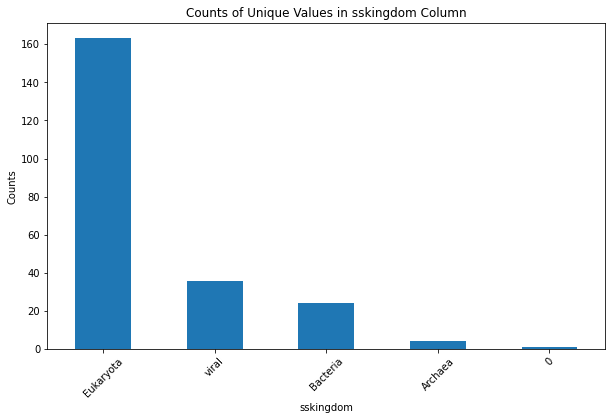

In [47]:
import matplotlib.pyplot as plt

# Plot the counts of unique values in the 'sskingdom' column
plt.figure(figsize=(10, 6))
results['sskingdom'].value_counts().plot(kind='bar')
plt.xlabel('sskingdom')
plt.ylabel('Counts')
plt.title('Counts of Unique Values in sskingdom Column')
plt.xticks(rotation=45)
plt.show()


In [55]:
# Initialize an empty list to collect the rows for the new DataFrame
filtered_data = []

# Group by 'contig_header' and analyze each group
for contig, group in results.groupby('contig_header'):
    # Find the most common value in 'sskingdom' and its proportion in the group
    most_common_value = group['sskingdom'].mode()[0]
    count_most_common = (group['sskingdom'] == most_common_value).sum()
    proportion = count_most_common / len(group)
    
    # If the most common value appears in more than 60% of the group, add it to the filtered data
    if proportion > 0.6:
        filtered_data.append({'contig_header': contig, 'sskingdom': most_common_value})

# Create a new DataFrame from the filtered data
filtered_df = pd.DataFrame(filtered_data)
#filtered_df.to_csv('Contig_kingdom_annoation_13_cand.csv')
filtered_df['MAG'] = filtered_df['contig_header'].str.extract(r'^(MAG[0-9]+)')
filtered_df

,contig_header,sskingdom,MAG
0,MAG07077_1,Eukaryota,MAG07077
1,MAG07077_2,Eukaryota,MAG07077
2,MAG07077_5,Eukaryota,MAG07077
3,MAG07077_6,Eukaryota,MAG07077
4,MAG07077_7,Eukaryota,MAG07077
...,...,...,...
109,MAG09696_6,Eukaryota,MAG09696
110,MAG09696_7,Eukaryota,MAG09696
111,MAG09707_1,Eukaryota,MAG09707
112,MAG09707_2,Eukaryota,MAG09707


In [56]:
viral_mags = filtered_df[filtered_df['sskingdom'] == 'viral']['MAG'].unique()
viral_mags
# Create a new DataFrame with only the relevant MAGs
#filtered_df = df[df['MAG'].isin(viral_mags)]

array(['MAG07145', 'MAG08011', 'MAG08959', 'MAG09322', 'MAG09374',
       'MAG09503'], dtype=object)

# For Circos plot 
1. Contig file 
2. Gene file (from gff)
3. 

# Update SCTLD_MAG file

Update: 4/11/2024 (nr host data)

Update: 24/10/24 

Update: 23/10/24

Made: 16/10/24

In [191]:
viral_taxa = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/viral_MAG_taxonomy.csv')
host_taxa = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/Host_taxa_per_mag.csv')
vr = pd.merge(viral_taxa, host_taxa, on="MAG")
gtdb = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/gtdb_merge.csv')
stats = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/SCTLD_MAG.csv')

v1 = pd.merge(stats, gtdb, on="MAG", how="left")
v2 = pd.merge(v1, vr, on="MAG", how="left")
v2.to_csv('24_10_24_SCTLD.csv')

In [59]:
df = pd.read_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/24_10_24_SCTLD.csv')
v3 = pd.merge(df, host_annotation, on="MAG", how="left")
v3.to_csv('/Users/shrinivas/Desktop/Dominican_Republic/SCTLD/04_11_2024_SCTLD.csv')